# **PROJETO APRENDIZAJE DE MAQUINA - PARTE II**

## BaseDeDatos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Librerias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

Importar el data set

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Cargar la hoja llamada "almuerzo" desde el archivo Excel
dataset = pd.read_excel('/content/drive/MyDrive/Base Asistencia Almuerzo y Cena (SIN-VACAS).xlsx', sheet_name ='Almuerzo')

# Normalizar (assuming columns 2:5 are numerical and need scaling)
scaler = StandardScaler()
columns_to_scale = dataset.iloc[:, 2:5]
dataset.iloc[:, 2:5] = scaler.fit_transform(columns_to_scale)

# 1. Seleccionar columnas que contienen "CatPrato"
categorical_cols = ['CatPrato', 'CatVegano', 'CatGuarnicao', 'CatSalada', 'CatSobremesa', 'CatSuco', 'Año', 'Día']

dataset = pd.get_dummies(dataset, columns=categorical_cols, drop_first=True, dtype=int)




# Verificar el dataset con las columnas escaladas y codificadas
print(dataset.head())

        Date  TOTAL      tavg      tmin      tmax  CatPrato_Especial  \
0  26/2/2024   4051  1.026011  1.348136  0.678322                  0   
1  27/2/2024   4499  1.341397  1.348136  1.198511                  1   
2  28/2/2024   6651  1.688322  1.977395  0.938417                  0   
3  29/2/2024   6325  1.656783  1.662765  1.198511                  0   
4   1/3/2024   5822  0.836780  1.033507  0.678322                  0   

   CatPrato_Frango  CatPrato_Peixe  CatPrato_Suína  \
0                0               0               1   
1                0               0               0   
2                0               0               0   
3                1               0               0   
4                0               0               1   

   CatVegano_PLATOS CON BASE DE LEGUMBRES  ...  CatSobremesa_MIXTO  \
0                                       0  ...                   0   
1                                       0  ...                   1   
2                               

In [ ]:
# dataset.head()
columnas = dataset.columns
print(columnas)

Index(['date', 'TOTAL', 'tavg', 'tmin', 'tmax', 'CatPrato_Especial',
       'CatPrato_Frango', 'CatPrato_Peixe', 'CatPrato_Suína',
       'CatVegano_PLATOS CON BASE DE LEGUMBRES',
       'CatVegano_PLATOS GUISADOS, ESTOFADOS O AL ESTILO REGIONAL',
       'CatVegano_PLATOS MIXTOS O COMBINADOS',
       'CatVegano_PREPARAÇÕES HORNEADAS O EMPANADAS',
       'CatGuarnicao_PLATOS CREMOSOS',
       'CatGuarnicao_PLATOS MIXTOS Y ESPECIALES',
       'CatGuarnicao_TUBÉRCULOS Y LEGUMBRES',
       'CatGuarnicao_VERDURAS Y HORTALIZAS DE HOJA ',
       'CatSalada_HOJAS VERDES Y SIMPLES', 'CatSalada_PREPARACION ESPECIAL',
       'CatSalada_RAYADOS', 'CatSobremesa_FRUTA',
       'CatSobremesa_Industrializados', 'CatSobremesa_MIXTO',
       'CatSuco_ÁCIDA ou Cítrica', 'CatSuco_Ácido-Adocicada', 'Año_2025',
       'Día_lunes', 'Día_martes', 'Día_miércoles', 'Día_sábado',
       'Día_viernes'],
      dtype='object')


Outliers

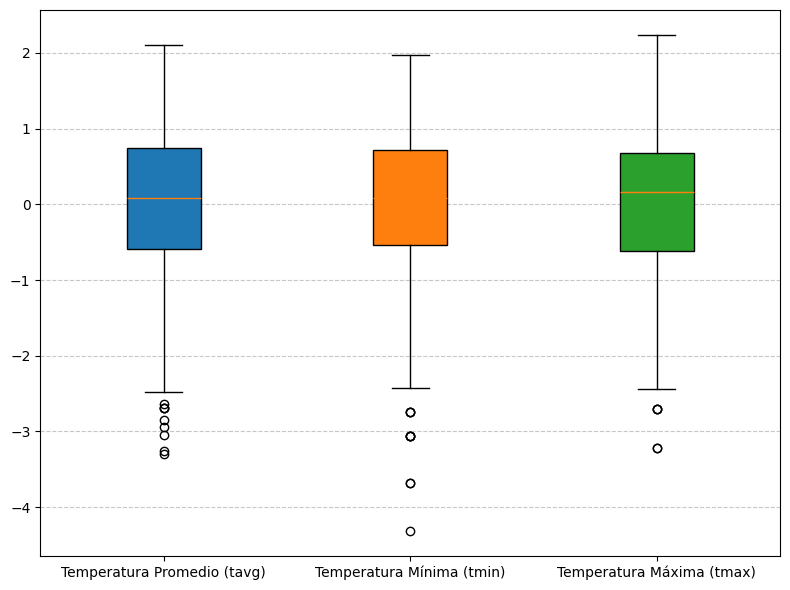

In [ ]:
import matplotlib.pyplot as plt

# Datos a graficar
data_to_plot = [dataset["tavg"], dataset["tmin"], dataset["tmax"]]

# Crear figura y tamaño
plt.figure(figsize=(8, 6))

# Boxplot con color personalizado
box = plt.boxplot(data_to_plot, patch_artist=True)

# Colores personalizados (opcional)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # azul, naranja, verde
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Etiquetas
plt.xticks([1, 2, 3], ['Temperatura Promedio (tavg)', 'Temperatura Mínima (tmin)', 'Temperatura Máxima (tmax)'], fontsize=10)
# plt.title("Distribución de Temperaturas", fontsize=14)
# plt.ylabel("Temperatura (°C)", fontsize=12)
# plt.xlabel("Variables", fontsize=12)

# Cuadrícula (opcional)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar gráfico
plt.tight_layout()
plt.show()



In [ ]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers[[column]]

numeric_values = ["TOTAL", "tavg", "tmin", "tmax"]

for i in numeric_values:
    outliers = detect_outliers_iqr(dataset, i)
    print(f"Outliers in {i}: {len(outliers)} values")

Outliers in TOTAL: 0 values
Outliers in tavg: 9 values
Outliers in tmin: 10 values
Outliers in tmax: 5 values


In [ ]:
print(dataset.iloc[:, 31])


0      0
1      0
2      0
3      0
4      1
      ..
371    0
372    1
373    0
374    0
375    0
Name: Día_viernes, Length: 376, dtype: int64


#Regression

In [ ]:
# HACER ESTO UNA SOLA VEZ AL PRINCIPIO DE TODO
from sklearn.model_selection import train_test_split

X = dataset.iloc[:, 2:33].values
y = dataset.iloc[:, 1].values

# Dividir una vez para todos los modelos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 1\) Arboles




In [ ]:
# print(dataset.iloc[:, 2:34].head())




       tavg      tmin      tmax  CatPrato_Especial  CatPrato_Frango  \
0  1.026011  1.348136  0.678322                  0                0   
1  1.341397  1.348136  1.198511                  1                0   
2  1.688322  1.977395  0.938417                  0                0   
3  1.656783  1.662765  1.198511                  0                1   
4  0.836780  1.033507  0.678322                  0                0   

   CatPrato_Peixe  CatPrato_Suína  CatVegano_PLATOS CON BASE DE LEGUMBRES  \
0               0               1                                       0   
1               0               0                                       0   
2               0               0                                       1   
3               0               0                                       1   
4               0               1                                       0   

   CatVegano_PLATOS GUISADOS, ESTOFADOS O AL ESTILO REGIONAL  \
0                                             

KeyError: 'comuna'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Variables
# X = dataset.iloc[:, 2:33].values  # 32 columnas predictoras (de la 2 a la 33)
# y = dataset.iloc[:, 1].values     # Columna objetivo

# Separar entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Tamaño de entrenamiento
n_train = X_train.shape[0]
p = X_train.shape[1]

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2  # Evitar división por cero
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# BÚSQUEDA DE MEJORES HIPERPARÁMETROS
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS...")

# Definir grid de parámetros
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Almacenar resultados
results = []

# Búsqueda exhaustiva
for max_depth in param_grid['max_depth']:
    for min_samples_split in param_grid['min_samples_split']:
        for min_samples_leaf in param_grid['min_samples_leaf']:

            # Crear modelo con parámetros actuales
            model = DecisionTreeRegressor(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42,
                criterion='squared_error'
            )

            # Entrenar y evaluar
            model.fit(X_train, y_train)
            y_pred_temp = model.predict(X_test)

            # Calcular métricas temporales
            r2_temp = r2_score(y_test, y_pred_temp)
            r2_adj_temp = adjusted_r2(r2_temp, X_test.shape[0], X_train.shape[1])
            mae_temp = mean_absolute_error(y_test, y_pred_temp)
            rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

            # Guardar resultados
            results.append({
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'r2_temp': r2_temp,
                'r2_adj_temp': r2_adj_temp,
                'mae_temp': mae_temp,
                'rmse_temp': rmse_temp
            })

# Convertir a DataFrame
results_df = pd.DataFrame(results)

# ============================================================================
# SELECCIÓN DEL MEJOR MODELO (R² ajustado + MAE)
# ============================================================================

print("\nSELECCIONANDO MEJOR MODELO...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 10 por R² ajustado y seleccionar el mejor MAE entre ellos
top_10_r2_adj = sorted_by_r2_adj.head(10)
best_model_params = top_10_r2_adj.sort_values('mae_temp').iloc[0]

# Convertir a tipos correctos (int o None)
max_depth_final = None if pd.isna(best_model_params['max_depth']) else int(best_model_params['max_depth'])
min_samples_split_final = int(best_model_params['min_samples_split'])
min_samples_leaf_final = int(best_model_params['min_samples_leaf'])

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   max_depth: {max_depth_final}")
print(f"   min_samples_split: {min_samples_split_final}")
print(f"   min_samples_leaf: {min_samples_leaf_final}")
print(f"   R² ajustado: {best_model_params['r2_adj_temp']:.4f}")
print(f"   MAE: {best_model_params['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO FINAL...")

# Crear el modelo final con mejores parámetros
regressorTree = DecisionTreeRegressor(
    max_depth=max_depth_final,
    min_samples_split=min_samples_split_final,
    min_samples_leaf=min_samples_leaf_final,
    random_state=42,
    criterion='squared_error'
)

# Entrenamiento del modelo
regressorTree.fit(X_train, y_train)

# -----------------------------------------------------------
# Evaluación Final en el conjunto de prueba (Test)
# -----------------------------------------------------------
y_pred_tree = regressorTree.predict(X_test)

n_test = X_test.shape[0]
r2_tree = r2_score(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
r2_adj_tree = adjusted_r2(r2_tree, n_test, p)
MAE_tree = mean_absolute_error(y_test, y_pred_tree)

print("--- Evaluación Final (Test) ---")
print(f"1. R² Final (Test) [r2_tree]: {r2_tree:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_tree]: {r2_adj_tree:.4f}")
print(f"3. MSE Final (Test) [mse_tree]: {mse_tree:.4f}")
print(f"4. RMSE Final (Test) [rmse_tree]: {rmse_tree:.2f}")
print(f"5. MAE Final (Test) [MAE_tree]: {MAE_tree:.2f}")

# -----------------------------------------------------------
# Validación Cruzada (K-Fold = 5)
# -----------------------------------------------------------
print("\n--- Validación Cruzada (K=5) ---")

cv_results = cross_validate(regressorTree, X_train, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'),
                            return_train_score=False)
cv_r2 = cross_val_score(regressorTree, X_train, y_train, cv=5, scoring='r2')

cv_r2_mean = cv_r2.mean()
cv_mse_mean = -cv_results['test_neg_mean_squared_error'].mean()
cv_rmse = np.sqrt(cv_mse_mean)
cv_r2_adj = adjusted_r2(cv_r2_mean, n_train, p)
cv_mae_mean = -cv_results['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean:.2f}")

# -----------------------------------------------------------
# TABLAS COMPARATIVAS
# -----------------------------------------------------------

print("\n" + "="*60)
print("TABLAS COMPARATIVAS")
print("="*60)

# Tabla 1: Primeros 10 modelos
print("\nTABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:")
display(results_df[['max_depth', 'min_samples_split', 'min_samples_leaf',
                   'r2_temp', 'r2_adj_temp', 'mae_temp', 'rmse_temp']].head(10))

# Tabla 2: TOP 5 R² ajustado
print("\nTOP 5 - MEJOR R² AJUSTADO:")
top5_r2_adj = results_df.nlargest(5, 'r2_adj_temp')[['max_depth', 'min_samples_split', 'min_samples_leaf', 'r2_adj_temp', 'mae_temp']]
display(top5_r2_adj)

# Tabla 3: TOP 5 MAE
print("\nTOP 5 - MEJOR MAE:")
top5_mae = results_df.nsmallest(5, 'mae_temp')[['max_depth', 'min_samples_split', 'min_samples_leaf', 'mae_temp', 'r2_adj_temp']]
display(top5_mae)

# -----------------------------------------------------------
# Predicción para un nuevo ejemplo (ACTUALIZADO: 6 días)
# -----------------------------------------------------------
print("\n--- Predicción ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6 (ACTUALIZADO: 6 días)
]

# Escalar primeras tres variables
sc = StandardScaler()
example_input_scaled = sc.fit_transform([example_input[:3]])  # tavg, tmin, tmax

# Resto del vector sin escalar
example_input_rest = np.array(example_input[3:]).reshape(1, -1)

# Concatenar escaladas + no escaladas
example_input_final = np.hstack([example_input_scaled, example_input_rest])

# Predicción
prediction_T = regressorTree.predict(example_input_final)
print(f"Predicción Árbol: {prediction_T[0]:,.2f}")



INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS...

SELECCIONANDO MEJOR MODELO...
MEJOR COMBINACIÓN ENCONTRADA:
   max_depth: 10
   min_samples_split: 5
   min_samples_leaf: 4
   R² ajustado: 0.6073
   MAE: 978.03

ENTRENANDO MODELO FINAL...
--- Evaluación Final (Test) ---
1. R² Final (Test) [r2_tree]: 0.7125
2. R² Ajustado Final (Test) [r2_adj_tree]: 0.6073
3. MSE Final (Test) [mse_tree]: 1950763.6441
4. RMSE Final (Test) [rmse_tree]: 1396.70
5. MAE Final (Test) [MAE_tree]: 978.03

--- Validación Cruzada (K=5) ---
R² Promedio (CV): 0.4942
R² Ajustado (CV): 0.4288
RMSE Promedio (CV): 1780.13
MAE Promedio (CV): 1194.17

TABLAS COMPARATIVAS

TABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:


,max_depth,min_samples_split,min_samples_leaf,r2_temp,r2_adj_temp,mae_temp,rmse_temp
0,3.0,2,1,0.197639,-0.095907,1861.811748,2333.285223
1,3.0,2,2,0.199882,-0.092844,1858.125907,2330.021599
2,3.0,2,4,0.199882,-0.092844,1858.125907,2330.021599
3,3.0,2,8,0.173311,-0.129136,1888.573016,2368.394679
4,3.0,5,1,0.197639,-0.095907,1861.811748,2333.285223
5,3.0,5,2,0.199882,-0.092844,1858.125907,2330.021599
6,3.0,5,4,0.199882,-0.092844,1858.125907,2330.021599
7,3.0,5,8,0.173311,-0.129136,1888.573016,2368.394679
8,3.0,10,1,0.197639,-0.095907,1861.811748,2333.285223
9,3.0,10,2,0.199882,-0.092844,1858.125907,2330.021599



TOP 5 - MEJOR R² AJUSTADO:


,max_depth,min_samples_split,min_samples_leaf,r2_adj_temp,mae_temp
46,10.0,20,4,0.610704,999.773417
62,15.0,20,4,0.610704,999.773417
78,20.0,20,4,0.610704,999.773417
94,NaN,20,4,0.610704,999.773417
34,10.0,2,4,0.607316,978.027474



TOP 5 - MEJOR MAE:


,max_depth,min_samples_split,min_samples_leaf,mae_temp,r2_adj_temp
44,10.0,20,1,954.934614,0.566941
60,15.0,20,1,954.934614,0.566941
76,20.0,20,1,954.934614,0.566941
92,NaN,20,1,954.934614,0.566941
34,10.0,2,4,978.027474,0.607316



--- Predicción ---
Predicción Árbol: 7,674.00

BUSQUEDA COMPLETADA - MODELO FINAL LISTO


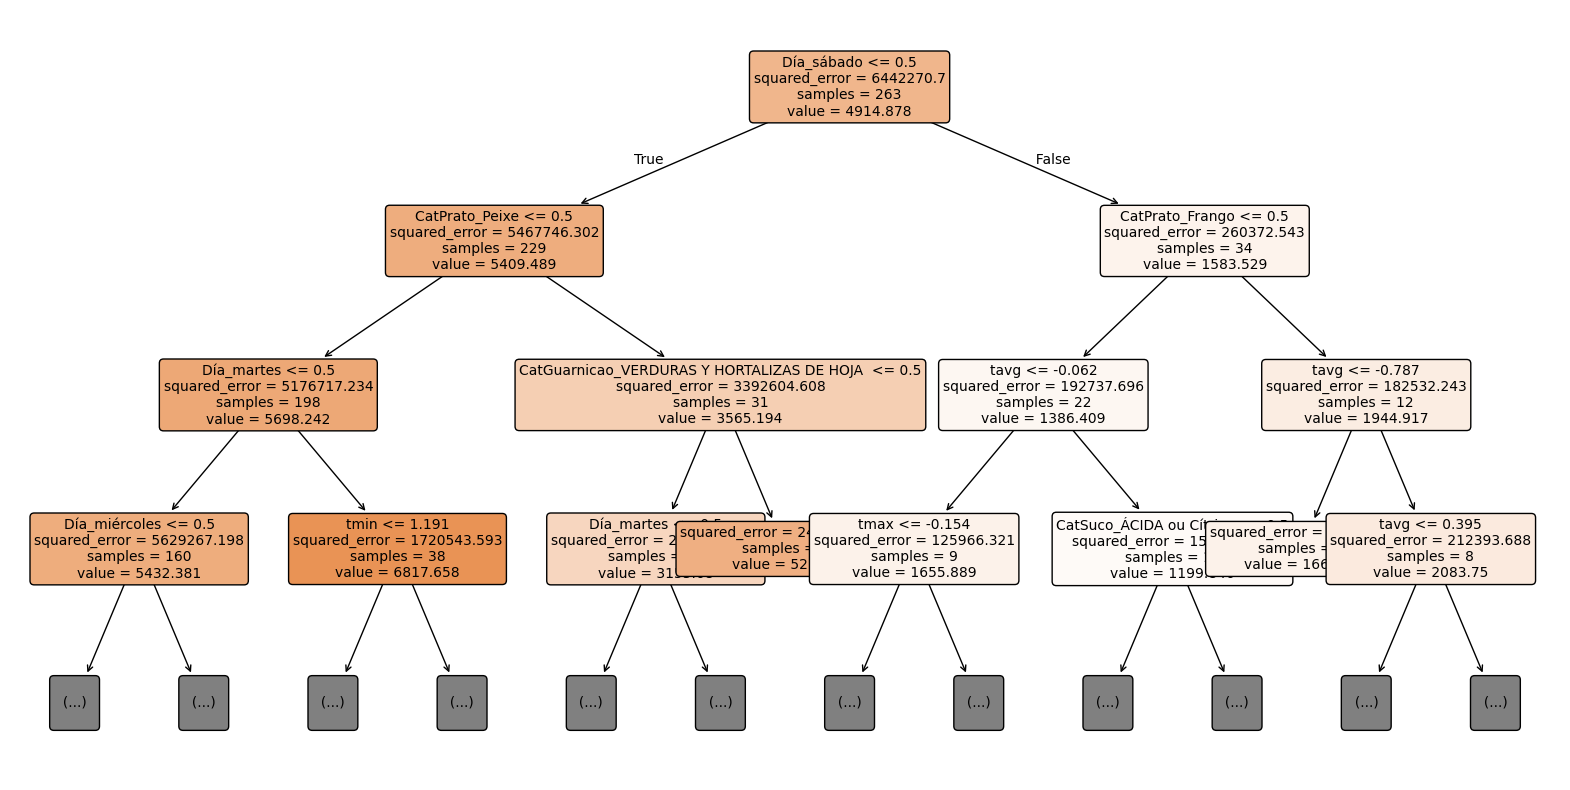

In [ ]:
# Visualización del árbol de decisión con una profundidad máxima de 4 niveles
plt.figure(figsize=(20, 10))  # Tamaño de la figura

# Usar el modelo con los mejores parámetros encontrados (regressorTree_best)
from sklearn import tree
tree.plot_tree(
    regressorTree,  # El árbol entrenado con los mejores parámetros
    feature_names=dataset.columns[2:33],  # Usar los nombres reales de las columnas de X_train
    filled=True,  # Colorear las hojas
    rounded=True,  # Bordes redondeados
    fontsize=10,  # Tamaño de la fuente
    max_depth= 3  # Limitar la profundidad del árbol a 4 niveles
)

plt.show()




--- Importancia de variables por Permutación ---


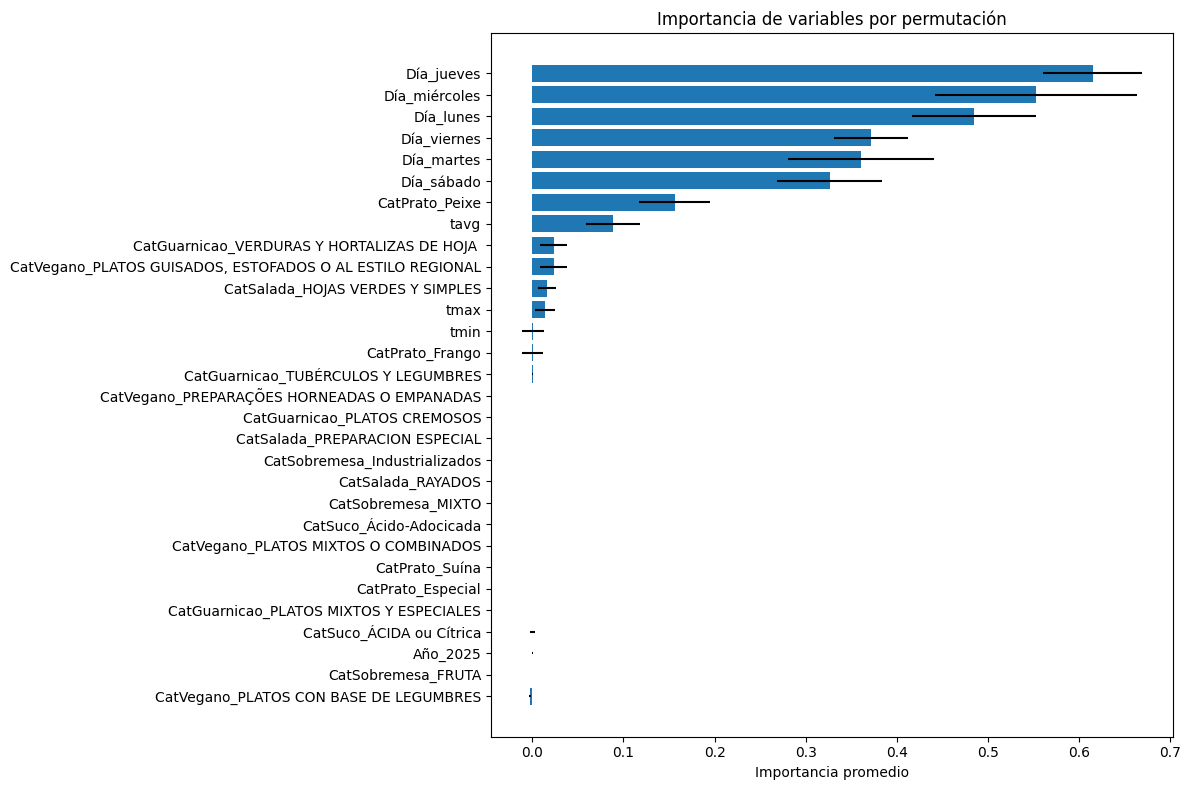

In [ ]:
from sklearn.inspection import permutation_importance

print("\n--- Importancia de variables por Permutación ---")

# Calcular la importancia de las variables con permutación
result = permutation_importance(
    regressorTree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Obtener la importancia promedio y la desviación estándar
importances = result.importances_mean
stds = result.importances_std

# Ordenar las variables por su importancia
indices = importances.argsort()

# Gráfico horizontal de la importancia de las variables
plt.figure(figsize=(12, 8))
plt.title("Importancia de variables por permutación")
plt.barh(range(p), importances[indices], xerr=stds[indices], align="center")
plt.yticks(range(p), dataset.columns[2:33][indices])  # Utilizar los nombres de las columnas reales
plt.xlabel("Importancia promedio")
plt.tight_layout()
plt.show()


## 2\) Random Forest Regression

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Variables
# X = dataset.iloc[:, 2:33].values
# y = dataset.iloc[:, 1].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

n_train = X_train.shape[0]
p = X_train.shape[1]

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# BÚSQUEDA DE MEJORES HIPERPARÁMETROS - RANDOM FOREST
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA RANDOM FOREST...")

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 8, 10, 15, 20, None],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 4, 8, 12],
    'max_features': ['sqrt'],
    'max_samples': [0.6, 0.7, 0.8, 1.0]
}

results_rf = []

# Contador para progreso
total_combinations = len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * \
                    len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf']) * \
                    len(param_grid_rf['max_samples'])
current = 0

print(f"Evaluando {total_combinations} combinaciones...")

for n_estimators in param_grid_rf['n_estimators']:
    for max_depth in param_grid_rf['max_depth']:
        for min_samples_split in param_grid_rf['min_samples_split']:
            for min_samples_leaf in param_grid_rf['min_samples_leaf']:
                for max_samples in param_grid_rf['max_samples']:

                    current += 1
                    if current % 50 == 0:
                        print(f"Progreso: {current}/{total_combinations}")

                    # Crear modelo
                    model = RandomForestRegressor(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        max_features='sqrt',
                        max_samples=max_samples,
                        random_state=42,
                        n_jobs=-1
                    )

                    # Entrenar y evaluar
                    model.fit(X_train, y_train)
                    y_pred_temp = model.predict(X_test)

                    # Calcular métricas
                    r2_temp = r2_score(y_test, y_pred_temp)
                    r2_adj_temp = adjusted_r2(r2_temp, X_test.shape[0], X_train.shape[1])
                    mae_temp = mean_absolute_error(y_test, y_pred_temp)
                    rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

                    # Guardar resultados
                    results_rf.append({
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'max_samples': max_samples,
                        'r2_temp': r2_temp,
                        'r2_adj_temp': r2_adj_temp,
                        'mae_temp': mae_temp,
                        'rmse_temp': rmse_temp
                    })

# Convertir a DataFrame
results_rf_df = pd.DataFrame(results_rf)

# ============================================================================
# SELECCIÓN DEL MEJOR MODELO (R² ajustado + MAE)
# ============================================================================

print("\nSELECCIONANDO MEJOR MODELO...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_rf_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 10 por R² ajustado y seleccionar el mejor MAE entre ellos
top_10_r2_adj = sorted_by_r2_adj.head(10)
best_model_params = top_10_r2_adj.sort_values('mae_temp').iloc[0]

# Convertir a tipos correctos
max_depth_final = None if pd.isna(best_model_params['max_depth']) else int(best_model_params['max_depth'])
n_estimators_final = int(best_model_params['n_estimators'])
min_samples_split_final = int(best_model_params['min_samples_split'])
min_samples_leaf_final = int(best_model_params['min_samples_leaf'])
max_samples_final = best_model_params['max_samples']

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   n_estimators: {n_estimators_final}")
print(f"   max_depth: {max_depth_final}")
print(f"   min_samples_split: {min_samples_split_final}")
print(f"   min_samples_leaf: {min_samples_leaf_final}")
print(f"   max_samples: {max_samples_final}")
print(f"   R² ajustado: {best_model_params['r2_adj_temp']:.4f}")
print(f"   MAE: {best_model_params['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO FINAL...")

regressorRandomForest = RandomForestRegressor(
    n_estimators=n_estimators_final,
    max_depth=max_depth_final,
    min_samples_split=min_samples_split_final,
    min_samples_leaf=min_samples_leaf_final,
    max_features='sqrt',
    max_samples=max_samples_final,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento del modelo
regressorRandomForest.fit(X_train, y_train)

# -----------------------------------------------------------
# Evaluación Final en el conjunto de prueba (Test)
# -----------------------------------------------------------
y_pred_RandomForest = regressorRandomForest.predict(X_test)

n_test = X_test.shape[0]
r2_RandomForest = r2_score(y_test, y_pred_RandomForest)
mse_RandomForest = mean_squared_error(y_test, y_pred_RandomForest)
rmse_RandomForest = np.sqrt(mse_RandomForest)
r2_adj_RandomForest = adjusted_r2(r2_RandomForest, n_test, p)
MAE_RandomForest = mean_absolute_error(y_test, y_pred_RandomForest)

print("--- Evaluación Final (Test) ---")
print(f"1. R² Final (Test) [r2_RandomForest]: {r2_RandomForest:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_RandomForest]: {r2_adj_RandomForest:.4f}")
print(f"3. MSE Final (Test) [mse_RandomForest]: {mse_RandomForest:.4f}")
print(f"4. RMSE Final (Test) [rmse_RandomForest]: {rmse_RandomForest:.2f}")
print(f"5. MAE Final (Test) [MAE_RandomForest]: {MAE_RandomForest:.2f}")

# -----------------------------------------------------------
# Validación Cruzada (K-Fold = 5)
# -----------------------------------------------------------
print("\n--- Validación Cruzada (K=5) ---")

cv_results = cross_validate(regressorRandomForest, X_train, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'),
                            return_train_score=False)
cv_r2 = cross_val_score(regressorRandomForest, X_train, y_train, cv=5, scoring='r2')

cv_r2_mean = cv_r2.mean()
cv_mse_mean = -cv_results['test_neg_mean_squared_error'].mean()
cv_rmse = np.sqrt(cv_mse_mean)
cv_r2_adj = adjusted_r2(cv_r2_mean, n_train, p)
cv_mae_mean = -cv_results['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean:.2f}")

# -----------------------------------------------------------
# TABLAS COMPARATIVAS
# -----------------------------------------------------------

print("\n" + "="*60)
print("TABLAS COMPARATIVAS - RANDOM FOREST")
print("="*60)

# Tabla 1: Primeros 10 modelos
print("\nTABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:")
display(results_rf_df[['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf',
                      'max_samples', 'r2_temp', 'r2_adj_temp', 'mae_temp']].head(10))

# Tabla 2: TOP 5 R² ajustado
print("\nTOP 5 - MEJOR R² AJUSTADO:")
top5_r2_adj = results_rf_df.nlargest(5, 'r2_adj_temp')[['n_estimators', 'max_depth', 'min_samples_split',
                                                       'min_samples_leaf', 'max_samples', 'r2_adj_temp', 'mae_temp']]
display(top5_r2_adj)

# Tabla 3: TOP 5 MAE
print("\nTOP 5 - MEJOR MAE:")
top5_mae = results_rf_df.nsmallest(5, 'mae_temp')[['n_estimators', 'max_depth', 'min_samples_split',
                                                  'min_samples_leaf', 'max_samples', 'mae_temp', 'r2_adj_temp']]
display(top5_mae)

# -----------------------------------------------------------
# Predicción para un nuevo ejemplo
# -----------------------------------------------------------
print("\n--- Predicción ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6
]

# Escalar primeras tres variables
sc = StandardScaler()
example_input_scaled = sc.fit_transform([example_input[:3]])

# Resto del vector sin escalar
example_input_rest = np.array(example_input[3:]).reshape(1, -1)

# Concatenar escaladas + no escaladas
example_input_final = np.hstack([example_input_scaled, example_input_rest])

# Predicción
prediction_RF = regressorRandomForest.predict(example_input_final)
print(f"Predicción Random Forest: {prediction_RF[0]:,.2f}")


INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA RANDOM FOREST...
Evaluando 1344 combinaciones...
Progreso: 50/1344
Progreso: 100/1344
Progreso: 150/1344
Progreso: 200/1344
Progreso: 250/1344
Progreso: 300/1344
Progreso: 350/1344
Progreso: 400/1344
Progreso: 450/1344
Progreso: 500/1344
Progreso: 550/1344
Progreso: 600/1344
Progreso: 650/1344
Progreso: 700/1344
Progreso: 750/1344
Progreso: 800/1344
Progreso: 850/1344
Progreso: 900/1344
Progreso: 950/1344
Progreso: 1000/1344
Progreso: 1050/1344
Progreso: 1100/1344
Progreso: 1150/1344
Progreso: 1200/1344
Progreso: 1250/1344
Progreso: 1300/1344

SELECCIONANDO MEJOR MODELO...
MEJOR COMBINACIÓN ENCONTRADA:
   n_estimators: 200
   max_depth: 20
   min_samples_split: 5
   min_samples_leaf: 2
   max_samples: 1.0
   R² ajustado: 0.2856
   MAE: 1559.75

ENTRENANDO MODELO FINAL...
--- Evaluación Final (Test) ---
1. R² Final (Test) [r2_RandomForest]: 0.4769
2. R² Ajustado Final (Test) [r2_adj_RandomForest]: 0.2856
3. MSE Final (Test) [mse_RandomF

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_samples,r2_temp,r2_adj_temp,mae_temp
0,100,3.0,5,2,0.6,0.224220,-0.059602,2010.503119
1,100,3.0,5,2,0.7,0.229024,-0.053041,2007.488034
2,100,3.0,5,2,0.8,0.236993,-0.042155,1992.714415
3,100,3.0,5,2,1.0,0.244505,-0.031896,1989.599943
4,100,3.0,5,4,0.6,0.223483,-0.060609,2015.727254
5,100,3.0,5,4,0.7,0.227249,-0.055465,2013.139043
6,100,3.0,5,4,0.8,0.228812,-0.053330,2007.520662
7,100,3.0,5,4,1.0,0.242679,-0.034390,1993.780868
8,100,3.0,5,8,0.6,0.218701,-0.067140,2035.591761
9,100,3.0,5,8,0.7,0.221139,-0.063811,2030.381859



TOP 5 - MEJOR R² AJUSTADO:


,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_samples,r2_adj_temp,mae_temp
1219,300,20.0,5,2,1.0,0.287160,1563.082640
1283,300,NaN,5,2,1.0,0.287160,1563.082640
771,200,20.0,5,2,1.0,0.285578,1559.748694
835,200,NaN,5,2,1.0,0.285578,1559.748694
1154,300,15.0,5,2,0.8,0.280465,1584.689124



TOP 5 - MEJOR MAE:


,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_samples,mae_temp,r2_adj_temp
771,200,20.0,5,2,1.0,1559.748694,0.285578
835,200,NaN,5,2,1.0,1559.748694,0.285578
1219,300,20.0,5,2,1.0,1563.082640,0.287160
1283,300,NaN,5,2,1.0,1563.082640,0.287160
323,100,20.0,5,2,1.0,1567.158892,0.273003



--- Predicción ---
Predicción Random Forest: 5,958.95

BUSQUEDA COMPLETADA - MODELO RANDOM FOREST FINAL LISTO


## 3\) XGBoost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Variables
# X = dataset.iloc[:, 2:33].values
# y = dataset.iloc[:, 1].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

n_train = X_train.shape[0]
p = X_train.shape[1]

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# BÚSQUEDA DE MEJORES HIPERPARÁMETROS - XGBOOST
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA XGBOOST...")

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 1, 10],
    'reg_lambda': [1, 10]
}

results_xgb = []

# Contador para progreso
total_combinations = len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['max_depth']) * \
                    len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['subsample']) * \
                    len(param_grid_xgb['colsample_bytree']) * len(param_grid_xgb['reg_alpha']) * \
                    len(param_grid_xgb['reg_lambda'])
current = 0

print(f"Evaluando {total_combinations} combinaciones...")

for n_estimators in param_grid_xgb['n_estimators']:
    for max_depth in param_grid_xgb['max_depth']:
        for learning_rate in param_grid_xgb['learning_rate']:
            for subsample in param_grid_xgb['subsample']:
                for colsample_bytree in param_grid_xgb['colsample_bytree']:
                    for reg_alpha in param_grid_xgb['reg_alpha']:
                        for reg_lambda in param_grid_xgb['reg_lambda']:

                            current += 1
                            if current % 100 == 0:
                                print(f"Progreso: {current}/{total_combinations}")

                            # Crear modelo
                            model = XGBRegressor(
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                learning_rate=learning_rate,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree,
                                reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                random_state=42,
                                n_jobs=-1
                            )

                            # Entrenar y evaluar
                            model.fit(X_train, y_train)
                            y_pred_temp = model.predict(X_test)

                            # Calcular métricas
                            r2_temp = r2_score(y_test, y_pred_temp)
                            r2_adj_temp = adjusted_r2(r2_temp, X_test.shape[0], X_train.shape[1])
                            mae_temp = mean_absolute_error(y_test, y_pred_temp)
                            rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

                            # Guardar resultados
                            results_xgb.append({
                                'n_estimators': n_estimators,
                                'max_depth': max_depth,
                                'learning_rate': learning_rate,
                                'subsample': subsample,
                                'colsample_bytree': colsample_bytree,
                                'reg_alpha': reg_alpha,
                                'reg_lambda': reg_lambda,
                                'r2_temp': r2_temp,
                                'r2_adj_temp': r2_adj_temp,
                                'mae_temp': mae_temp,
                                'rmse_temp': rmse_temp
                            })

# Convertir a DataFrame
results_xgb_df = pd.DataFrame(results_xgb)

# ============================================================================
# SELECCIÓN DEL MEJOR MODELO (R² ajustado + MAE)
# ============================================================================

print("\nSELECCIONANDO MEJOR MODELO...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_xgb_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 10 por R² ajustado y seleccionar el mejor MAE entre ellos
top_10_r2_adj = sorted_by_r2_adj.head(10)
best_model_params = top_10_r2_adj.sort_values('mae_temp').iloc[0]

# Convertir a tipos correctos
n_estimators_final = int(best_model_params['n_estimators'])
max_depth_final = int(best_model_params['max_depth'])
learning_rate_final = best_model_params['learning_rate']
subsample_final = best_model_params['subsample']
colsample_bytree_final = best_model_params['colsample_bytree']
reg_alpha_final = best_model_params['reg_alpha']
reg_lambda_final = best_model_params['reg_lambda']

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   n_estimators: {n_estimators_final}")
print(f"   max_depth: {max_depth_final}")
print(f"   learning_rate: {learning_rate_final}")
print(f"   subsample: {subsample_final}")
print(f"   colsample_bytree: {colsample_bytree_final}")
print(f"   reg_alpha: {reg_alpha_final}")
print(f"   reg_lambda: {reg_lambda_final}")
print(f"   R² ajustado: {best_model_params['r2_adj_temp']:.4f}")
print(f"   MAE: {best_model_params['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO FINAL...")

regressorXGB = XGBRegressor(
    n_estimators=n_estimators_final,
    max_depth=max_depth_final,
    learning_rate=learning_rate_final,
    subsample=subsample_final,
    colsample_bytree=colsample_bytree_final,
    reg_alpha=reg_alpha_final,
    reg_lambda=reg_lambda_final,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento del modelo
regressorXGB.fit(X_train, y_train)

# -----------------------------------------------------------
# Evaluación Final en el conjunto de prueba (Test)
# -----------------------------------------------------------
y_pred_XGB = regressorXGB.predict(X_test)

n_test = X_test.shape[0]
r2_XGB = r2_score(y_test, y_pred_XGB)
mse_XGB = mean_squared_error(y_test, y_pred_XGB)
rmse_XGB = np.sqrt(mse_XGB)
r2_adj_XGB = adjusted_r2(r2_XGB, n_test, p)
MAE_XGB = mean_absolute_error(y_test, y_pred_XGB)

print("--- Evaluación Final (Test) ---")
print(f"1. R² Final (Test) [r2_XGB]: {r2_XGB:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_XGB]: {r2_adj_XGB:.4f}")
print(f"3. MSE Final (Test) [mse_XGB]: {mse_XGB:.4f}")
print(f"4. RMSE Final (Test) [rmse_XGB]: {rmse_XGB:.2f}")
print(f"5. MAE Final (Test) [MAE_XGB]: {MAE_XGB:.2f}")

# -----------------------------------------------------------
# Validación Cruzada (K-Fold = 5)
# -----------------------------------------------------------
print("\n--- Validación Cruzada (K=5) ---")

cv_results = cross_validate(regressorXGB, X_train, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'),
                            return_train_score=False)
cv_r2 = cross_val_score(regressorXGB, X_train, y_train, cv=5, scoring='r2')

cv_r2_mean = cv_r2.mean()
cv_mse_mean = -cv_results['test_neg_mean_squared_error'].mean()
cv_rmse = np.sqrt(cv_mse_mean)
cv_r2_adj = adjusted_r2(cv_r2_mean, n_train, p)
cv_mae_mean = -cv_results['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean:.2f}")

# -----------------------------------------------------------
# TABLAS COMPARATIVAS
# -----------------------------------------------------------

print("\n" + "="*60)
print("TABLAS COMPARATIVAS - XGBOOST")
print("="*60)

# Tabla 1: Primeros 10 modelos
print("\nTABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:")
display(results_xgb_df[['n_estimators', 'max_depth', 'learning_rate', 'subsample',
                       'colsample_bytree', 'reg_alpha', 'reg_lambda', 'r2_temp',
                       'r2_adj_temp', 'mae_temp']].head(10))

# Tabla 2: TOP 5 R² ajustado
print("\nTOP 5 - MEJOR R² AJUSTADO:")
top5_r2_adj = results_xgb_df.nlargest(5, 'r2_adj_temp')[['n_estimators', 'max_depth', 'learning_rate',
                                                        'subsample', 'colsample_bytree', 'reg_alpha',
                                                        'reg_lambda', 'r2_adj_temp', 'mae_temp']]
display(top5_r2_adj)

# Tabla 3: TOP 5 MAE
print("\nTOP 5 - MEJOR MAE:")
top5_mae = results_xgb_df.nsmallest(5, 'mae_temp')[['n_estimators', 'max_depth', 'learning_rate',
                                                   'subsample', 'colsample_bytree', 'reg_alpha',
                                                   'reg_lambda', 'mae_temp', 'r2_adj_temp']]
display(top5_mae)

# -----------------------------------------------------------
# Predicción para un nuevo ejemplo
# -----------------------------------------------------------
print("\n--- Predicción ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6
]

# Escalar primeras tres variables
sc = StandardScaler()
example_input_scaled = sc.fit_transform([example_input[:3]])

# Resto del vector sin escalar
example_input_rest = np.array(example_input[3:]).reshape(1, -1)

# Concatenar escaladas + no escaladas
example_input_final = np.hstack([example_input_scaled, example_input_rest])

# Predicción
prediction_XGB = regressorXGB.predict(example_input_final)
print(f"Predicción XGBoost: {prediction_XGB[0]:,.2f}")



INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA XGBOOST...
Evaluando 1944 combinaciones...
Progreso: 100/1944
Progreso: 200/1944
Progreso: 300/1944
Progreso: 400/1944
Progreso: 500/1944
Progreso: 600/1944
Progreso: 700/1944
Progreso: 800/1944
Progreso: 900/1944
Progreso: 1000/1944
Progreso: 1100/1944
Progreso: 1200/1944
Progreso: 1300/1944
Progreso: 1400/1944
Progreso: 1500/1944
Progreso: 1600/1944
Progreso: 1700/1944
Progreso: 1800/1944
Progreso: 1900/1944

SELECCIONANDO MEJOR MODELO...
MEJOR COMBINACIÓN ENCONTRADA:
   n_estimators: 100
   max_depth: 5
   learning_rate: 0.2
   subsample: 1.0
   colsample_bytree: 0.7
   reg_alpha: 1.0
   reg_lambda: 1.0
   R² ajustado: 0.6297
   MAE: 999.24

ENTRENANDO MODELO FINAL...
--- Evaluación Final (Test) ---
1. R² Final (Test) [r2_XGB]: 0.7289
2. R² Ajustado Final (Test) [r2_adj_XGB]: 0.6297
3. MSE Final (Test) [mse_XGB]: 1839548.1250
4. RMSE Final (Test) [rmse_XGB]: 1356.30
5. MAE Final (Test) [MAE_XGB]: 999.24

--- Validación Cruzada (K=5)

,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,r2_temp,r2_adj_temp,mae_temp
0,100,3,0.05,0.7,0.7,0,1,0.520284,0.344778,1439.575195
1,100,3,0.05,0.7,0.7,0,10,0.479395,0.288930,1497.774170
2,100,3,0.05,0.7,0.7,1,1,0.520284,0.344778,1439.573364
3,100,3,0.05,0.7,0.7,1,10,0.479391,0.288925,1497.782959
4,100,3,0.05,0.7,0.7,10,1,0.520310,0.344814,1439.527344
5,100,3,0.05,0.7,0.7,10,10,0.479356,0.288876,1497.863281
6,100,3,0.05,0.7,0.8,0,1,0.534984,0.364856,1420.481323
7,100,3,0.05,0.7,0.8,0,10,0.493603,0.308336,1480.185669
8,100,3,0.05,0.7,0.8,1,1,0.534981,0.364852,1420.482666
9,100,3,0.05,0.7,0.8,1,10,0.493599,0.308331,1480.195435



TOP 5 - MEJOR R² AJUSTADO:


,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,r2_adj_temp,mae_temp
958,200,5,0.20,1.0,0.7,10,1,0.630517,1000.528687
1606,300,5,0.20,1.0,0.7,10,1,0.630437,1000.029785
308,100,5,0.20,1.0,0.7,1,1,0.629704,999.243774
1176,200,8,0.05,1.0,0.8,0,1,0.629448,1003.783630
1824,300,8,0.05,1.0,0.8,0,1,0.629395,1001.538391



TOP 5 - MEJOR MAE:


,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,mae_temp,r2_adj_temp
1288,200,8,0.2,1.0,0.8,10,1,978.289795,0.617796
1936,300,8,0.2,1.0,0.8,10,1,978.289795,0.617796
640,100,8,0.2,1.0,0.8,10,1,978.378418,0.617779
1068,200,7,0.1,1.0,0.8,0,1,990.056946,0.623794
1716,300,7,0.1,1.0,0.8,0,1,990.628296,0.623308



--- Predicción ---
Predicción XGBoost: 6,642.16

BUSQUEDA COMPLETADA - MODELO XGBOOST FINAL LISTO


## 4\) Maquina de soporte vectorial

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# -------------------------------------------------------------------
# Función para eliminar outliers usando IQR
# -------------------------------------------------------------------
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    return df_clean

# -------------------------------------------------------------------
# Limpiar dataset original y crear dataset_so (sin outliers)
# -------------------------------------------------------------------
numeric_values = ["tavg", "tmin", "tmax"]
dataset_so = remove_outliers_iqr(dataset, numeric_values)

# -------------------------------------------------------------------
# Preparar datos para modelo SVR
# -------------------------------------------------------------------
X = dataset_so.iloc[:, 2:33].values
y = dataset_so.iloc[:, 1].values     # Columna objetivo

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tamaños para R² ajustado
n_train = X_train_scaled.shape[0]
n_test = X_test_scaled.shape[0]
p = X_train_scaled.shape[1]

# Función para R² ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# BÚSQUEDA DE MEJORES HIPERPARÁMETROS - SVR (OPTIMIZADO)
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA SVR...")

param_grid_svr_optimizado = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.05, 0.1, 0.2],
    'gamma': ['scale', 'auto']
}

results_svr = []

# Contador para progreso
total_combinations = len(param_grid_svr_optimizado['kernel']) * len(param_grid_svr_optimizado['C']) * \
                    len(param_grid_svr_optimizado['epsilon']) * len(param_grid_svr_optimizado['gamma'])
current = 0

print(f"Evaluando {total_combinations} combinaciones...")

for kernel in param_grid_svr_optimizado['kernel']:
    for C in param_grid_svr_optimizado['C']:
        for epsilon in param_grid_svr_optimizado['epsilon']:
            for gamma in param_grid_svr_optimizado['gamma']:

                current += 1
                if current % 10 == 0:
                    print(f"Progreso: {current}/{total_combinations}")

                # Para kernel linear, gamma no se usa
                if kernel == 'linear':
                    model = SVR(kernel=kernel, C=C, epsilon=epsilon)
                else:
                    model = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)

                # Entrenar y evaluar
                model.fit(X_train_scaled, y_train)
                y_pred_temp = model.predict(X_test_scaled)

                # Calcular métricas
                r2_temp = r2_score(y_test, y_pred_temp)
                r2_adj_temp = adjusted_r2(r2_temp, n_test, p)
                mae_temp = mean_absolute_error(y_test, y_pred_temp)
                rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

                # Guardar resultados
                results_svr.append({
                    'kernel': kernel,
                    'C': C,
                    'epsilon': epsilon,
                    'gamma': gamma,
                    'r2_temp': r2_temp,
                    'r2_adj_temp': r2_adj_temp,
                    'mae_temp': mae_temp,
                    'rmse_temp': rmse_temp
                })

# Convertir a DataFrame
results_svr_df = pd.DataFrame(results_svr)

# ============================================================================
# SELECCIÓN DEL MEJOR MODELO (R² ajustado + MAE)
# ============================================================================

print("\nSELECCIONANDO MEJOR MODELO...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_svr_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 10 por R² ajustado y seleccionar el mejor MAE entre ellos
top_10_r2_adj = sorted_by_r2_adj.head(10)
best_model_params = top_10_r2_adj.sort_values('mae_temp').iloc[0]

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   kernel: {best_model_params['kernel']}")
print(f"   C: {best_model_params['C']}")
print(f"   epsilon: {best_model_params['epsilon']}")
print(f"   gamma: {best_model_params['gamma']}")
print(f"   R² ajustado: {best_model_params['r2_adj_temp']:.4f}")
print(f"   MAE: {best_model_params['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO FINAL...")

# Crear modelo final con mejores parámetros
kernel_final = best_model_params['kernel']
C_final = best_model_params['C']
epsilon_final = best_model_params['epsilon']
gamma_final = best_model_params['gamma']

if kernel_final == 'linear':
    regressorSVR = SVR(kernel=kernel_final, C=C_final, epsilon=epsilon_final)
else:
    regressorSVR = SVR(kernel=kernel_final, C=C_final, epsilon=epsilon_final, gamma=gamma_final)

# Entrenamiento del modelo
regressorSVR.fit(X_train_scaled, y_train)

# -------------------------------------------------------------------
# Evaluación en conjunto de prueba
# -------------------------------------------------------------------
print("\n--- Evaluación Final (Test) ---")
y_pred_SVR = regressorSVR.predict(X_test_scaled)

r2_SVR = r2_score(y_test, y_pred_SVR)
mse_SVR = mean_squared_error(y_test, y_pred_SVR)
rmse_SVR = np.sqrt(mse_SVR)
r2_adj_SVR = adjusted_r2(r2_SVR, n_test, p)
MAE_SVR = mean_absolute_error(y_test, y_pred_SVR)

print(f"1. R² Final (Test) [r2_SVR]: {r2_SVR:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_SVR]: {r2_adj_SVR:.4f}")
print(f"3. MSE Final (Test) [mse_SVR]: {mse_SVR:.4f}")
print(f"4. RMSE Final (Test) [rmse_SVR]: {rmse_SVR:.2f}")
print(f"5. MAE Final (Test) [MAE_SVR]: {MAE_SVR:.2f}")

# -------------------------------------------------------------------
# Validación cruzada (K=5)
# -------------------------------------------------------------------
print("\n--- Validación Cruzada (K=5) ---")
cv_results = cross_validate(regressorSVR, X_train_scaled, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'),
                            return_train_score=False)
cv_r2 = cross_val_score(regressorSVR, X_train_scaled, y_train, cv=5, scoring='r2')

cv_r2_mean = cv_r2.mean()
cv_mse_mean = -cv_results['test_neg_mean_squared_error'].mean()
cv_rmse = np.sqrt(cv_mse_mean)
cv_r2_adj = adjusted_r2(cv_r2_mean, n_train, p)
cv_mae_mean = -cv_results['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean:.2f}")

# -----------------------------------------------------------
# TABLAS COMPARATIVAS
# -----------------------------------------------------------

print("\n" + "="*60)
print("TABLAS COMPARATIVAS - SVR")
print("="*60)

# Tabla 1: Primeros 10 modelos
print("\nTABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:")
display(results_svr_df[['kernel', 'C', 'epsilon', 'gamma', 'r2_temp',
                       'r2_adj_temp', 'mae_temp', 'rmse_temp']].head(10))

# Tabla 2: TOP 5 R² ajustado
print("\nTOP 5 - MEJOR R² AJUSTADO:")
top5_r2_adj = results_svr_df.nlargest(5, 'r2_adj_temp')[['kernel', 'C', 'epsilon',
                                                        'gamma', 'r2_adj_temp', 'mae_temp']]
display(top5_r2_adj)

# Tabla 3: TOP 5 MAE
print("\nTOP 5 - MEJOR MAE:")
top5_mae = results_svr_df.nsmallest(5, 'mae_temp')[['kernel', 'C', 'epsilon',
                                                   'gamma', 'mae_temp', 'r2_adj_temp']]
display(top5_mae)

# -------------------------------------------------------------------
# Predicción para nuevo ejemplo
# -------------------------------------------------------------------
print("\n--- Predicción para nuevo ejemplo ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CatPrato (4)
    0, 1, 0, 0,        # CatVegano (4)
    0, 1, 0, 0,        # CatGuarnicao (4)
    1, 0, 0,           # CatSalada (3)
    1, 0, 0,           # CatSobremesa (3)
    0, 0,              # CatSuco (2)
    1,                 # Año (1)
    0, 1, 0, 0, 0, 0   # Día (6)
]

# Asegúrate de que la longitud sea igual a X.shape[1]
assert len(example_input) == X.shape[1], "Longitud del input no coincide con las columnas de entrenamiento"

# Escalar el nuevo input con el scaler original
example_input_scaled = scaler.transform([example_input])
prediction_SVR = regressorSVR.predict(example_input_scaled)

print(f"Predicción SVR: {prediction_SVR[0]:,.2f}")


INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA SVR...
Evaluando 36 combinaciones...
Progreso: 10/36
Progreso: 20/36
Progreso: 30/36

SELECCIONANDO MEJOR MODELO...
MEJOR COMBINACIÓN ENCONTRADA:
   kernel: linear
   C: 10.0
   epsilon: 0.2
   gamma: auto
   R² ajustado: 0.0863
   MAE: 1576.45

ENTRENANDO MODELO FINAL...

--- Evaluación Final (Test) ---
1. R² Final (Test) [r2_SVR]: 0.3378
2. R² Ajustado Final (Test) [r2_adj_SVR]: 0.0863
3. MSE Final (Test) [mse_SVR]: 4446071.0955
4. RMSE Final (Test) [rmse_SVR]: 2108.57
5. MAE Final (Test) [MAE_SVR]: 1576.45

--- Validación Cruzada (K=5) ---
R² Promedio (CV): 0.3226
R² Ajustado (CV): 0.2314
RMSE Promedio (CV): 2073.06
MAE Promedio (CV): 1581.72

TABLAS COMPARATIVAS - SVR

TABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:


,kernel,C,epsilon,gamma,r2_temp,r2_adj_temp,mae_temp,rmse_temp
0,linear,0.1,0.05,scale,-0.148948,-0.585257,2208.052185,2777.380200
1,linear,0.1,0.05,auto,-0.148948,-0.585257,2208.052185,2777.380200
2,linear,0.1,0.10,scale,-0.148948,-0.585257,2208.052185,2777.380200
3,linear,0.1,0.10,auto,-0.148948,-0.585257,2208.052185,2777.380200
4,linear,0.1,0.20,scale,-0.148948,-0.585257,2208.052185,2777.380200
5,linear,0.1,0.20,auto,-0.148948,-0.585257,2208.052185,2777.380200
6,linear,1.0,0.05,scale,-0.077613,-0.486833,2124.474565,2689.779048
7,linear,1.0,0.05,auto,-0.077613,-0.486833,2124.474565,2689.779048
8,linear,1.0,0.10,scale,-0.077613,-0.486833,2124.474565,2689.779048
9,linear,1.0,0.10,auto,-0.077613,-0.486833,2124.474565,2689.779048



TOP 5 - MEJOR R² AJUSTADO:


,kernel,C,epsilon,gamma,r2_adj_temp,mae_temp
16,linear,10.0,0.20,scale,0.086296,1576.451714
17,linear,10.0,0.20,auto,0.086296,1576.451714
14,linear,10.0,0.10,scale,0.086289,1576.454603
15,linear,10.0,0.10,auto,0.086289,1576.454603
12,linear,10.0,0.05,scale,0.086286,1576.456051



TOP 5 - MEJOR MAE:


,kernel,C,epsilon,gamma,mae_temp,r2_adj_temp
16,linear,10.0,0.20,scale,1576.451714,0.086296
17,linear,10.0,0.20,auto,1576.451714,0.086296
14,linear,10.0,0.10,scale,1576.454603,0.086289
15,linear,10.0,0.10,auto,1576.454603,0.086289
12,linear,10.0,0.05,scale,1576.456051,0.086286



--- Predicción para nuevo ejemplo ---
Predicción SVR: 7,807.80

BUSQUEDA COMPLETADA - MODELO SVR FINAL LISTO


In [ ]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers[[column]]

numeric_values = ["TOTAL", "tavg", "tmin", "tmax"]

for i in numeric_values:
    outliers = detect_outliers_iqr(dataset_so, i)
    print(f"Outliers in {i}: {len(outliers)} values")

Outliers in TOTAL: 0 values
Outliers in tavg: 2 values
Outliers in tmin: 0 values
Outliers in tmax: 0 values


## 5\) Ensemble hetereogeneo

### Ensemble con Voting e pesos


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Configuración
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURACIÓN DE MODELOS BASE CON MEJORES PARÁMETROS
# ============================================================================

print("CONFIGURANDO MODELOS BASE CON MEJORES PARÁMETROS...")

# Modelos base con mejores parámetros encontrados
modelos_base_configs = {
    'tree': DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=4,
        random_state=42
    ),
    'rf': RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_samples=1.0,
        random_state=42,
        n_jobs=-1
    ),
    'xgb': XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.2,
        subsample=1.0,
        colsample_bytree=0.7,
        reg_alpha=1.0,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
}

# ============================================================================
# BÚSQUEDA DE MEJORES COMBINACIONES DE ENSEMBLE
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES COMBINACIONES DE ENSEMBLE...")

# Diferentes combinaciones de modelos y pesos (solo combinaciones de 2-3 modelos)
combinaciones_ensemble = [
    # Pesos balanceados
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [1, 1, 1],
        'nombre': 'Todos_Iguales'
    },
    # Énfasis en Random Forest
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [1, 3, 2],
        'nombre': 'RF_Primario'
    },
    # Énfasis en XGBoost
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [1, 2, 3],
        'nombre': 'XGB_Primario'
    },
    # Énfasis en Árbol + RF
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [3, 2, 1],
        'nombre': 'Arbol_RF_Fuerte'
    },
    # Progresivo ascendente
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [1, 2, 3],
        'nombre': 'Progresivo_Asc'
    },
    # Progresivo descendente
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [3, 2, 1],
        'nombre': 'Progresivo_Desc'
    },
    # RF como claro líder
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [1, 4, 2],
        'nombre': 'RF_Lider'
    },
    # XGB como claro líder
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [1, 2, 4],
        'nombre': 'XGB_Lider'
    },
    # Solo RF y XGB (sin árbol)
    {
        'modelos': ['rf', 'xgb'],
        'pesos': [2, 3],
        'nombre': 'RF_XGB_Fuerte'
    },
    # Solo RF y XGB balanceado
    {
        'modelos': ['rf', 'xgb'],
        'pesos': [1, 1],
        'nombre': 'RF_XGB_Balance'
    }
]

results_ensemble = []

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Evaluar cada combinación
for combo in combinaciones_ensemble:
    print(f"Evaluando combinación: {combo['nombre']}")

    # Crear lista de modelos para VotingRegressor
    modelos_voting = []
    for modelo_nombre in combo['modelos']:
        modelos_voting.append((modelo_nombre, modelos_base_configs[modelo_nombre]))

    # Crear y entrenar VotingRegressor
    ensemble = VotingRegressor(estimators=modelos_voting, weights=combo['pesos'])
    ensemble.fit(X_train, y_train)

    # Evaluar en test
    y_pred_temp = ensemble.predict(X_test)

    # Calcular métricas
    r2_temp = r2_score(y_test, y_pred_temp)
    r2_adj_temp = adjusted_r2(r2_temp, X_test.shape[0], X_train.shape[1])
    mae_temp = mean_absolute_error(y_test, y_pred_temp)
    rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

    # Guardar resultados
    results_ensemble.append({
        'combinacion': combo['nombre'],
        'modelos': ', '.join(combo['modelos']),
        'pesos': str(combo['pesos']),
        'r2_temp': r2_temp,
        'r2_adj_temp': r2_adj_temp,
        'mae_temp': mae_temp,
        'rmse_temp': rmse_temp
    })

# Convertir a DataFrame
results_ensemble_df = pd.DataFrame(results_ensemble)

# ============================================================================
# SELECCIÓN DEL MEJOR ENSEMBLE
# ============================================================================

print("\nSELECCIONANDO MEJOR COMBINACIÓN...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_ensemble_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 5 por R² ajustado y seleccionar el mejor MAE entre ellos
top_5_r2_adj = sorted_by_r2_adj.head(5)
best_combo = top_5_r2_adj.sort_values('mae_temp').iloc[0]

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   Nombre: {best_combo['combinacion']}")
print(f"   Modelos: {best_combo['modelos']}")
print(f"   Pesos: {best_combo['pesos']}")
print(f"   R² ajustado: {best_combo['r2_adj_temp']:.4f}")
print(f"   MAE: {best_combo['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO ENSEMBLE FINAL...")

# Encontrar la combinación ganadora
combinacion_ganadora = None
for combo in combinaciones_ensemble:
    if combo['nombre'] == best_combo['combinacion']:
        combinacion_ganadora = combo
        break

# Crear modelo final
modelos_final = []
for modelo_nombre in combinacion_ganadora['modelos']:
    modelos_final.append((modelo_nombre, modelos_base_configs[modelo_nombre]))

regressorEnsemble = VotingRegressor(
    estimators=modelos_final,
    weights=combinacion_ganadora['pesos']
)

# Entrenamiento del modelo final
regressorEnsemble.fit(X_train, y_train)

# ============================================================================
# EVALUACIÓN FINAL
# ============================================================================

print("\n--- Evaluación Final (Test) ---")
y_pred_ensemble = regressorEnsemble.predict(X_test)

n_test = X_test.shape[0]
p = X_train.shape[1]

r2_ensemble = r2_score(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
r2_adj_ensemble = adjusted_r2(r2_ensemble, n_test, p)
MAE_ensemble = mean_absolute_error(y_test, y_pred_ensemble)

print(f"1. R² Final (Test) [r2_ensemble]: {r2_ensemble:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_ensemble]: {r2_adj_ensemble:.4f}")
print(f"3. MSE Final (Test) [mse_ensemble]: {mse_ensemble:.4f}")
print(f"4. RMSE Final (Test) [rmse_ensemble]: {rmse_ensemble:.2f}")
print(f"5. MAE Final (Test) [MAE_ensemble]: {MAE_ensemble:.2f}")

# Validación Cruzada
print("\n--- Validación Cruzada (K=5) ---")
cv_results = cross_validate(regressorEnsemble, X_train, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'),
                            return_train_score=False)
cv_r2 = cross_val_score(regressorEnsemble, X_train, y_train, cv=5, scoring='r2')

cv_r2_mean = cv_r2.mean()
cv_mse_mean = -cv_results['test_neg_mean_squared_error'].mean()
cv_rmse = np.sqrt(cv_mse_mean)
cv_r2_adj = adjusted_r2(cv_r2_mean, X_train.shape[0], p)
cv_mae_mean = -cv_results['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean:.2f}")

# ============================================================================
# TABLAS COMPARATIVAS
# ============================================================================

print("\n" + "="*60)
print("TABLAS COMPARATIVAS - ENSEMBLE")
print("="*60)

# Tabla completa de resultados
print("\nTODAS LAS COMBINACIONES EVALUADAS:")
display(results_ensemble_df[['combinacion', 'modelos', 'pesos', 'r2_temp',
                            'r2_adj_temp', 'mae_temp', 'rmse_temp']])

# Tabla: TOP 3 R² ajustado
print("\nTOP 3 - MEJOR R² AJUSTADO:")
top3_r2_adj = results_ensemble_df.nlargest(3, 'r2_adj_temp')[['combinacion', 'modelos',
                                                              'pesos', 'r2_adj_temp', 'mae_temp']]
display(top3_r2_adj)

# Tabla: TOP 3 MAE
print("\nTOP 3 - MEJOR MAE:")
top3_mae = results_ensemble_df.nsmallest(3, 'mae_temp')[['combinacion', 'modelos',
                                                        'pesos', 'mae_temp', 'r2_adj_temp']]
display(top3_mae)

# ============================================================================
# PREDICCIÓN
# ============================================================================

print("\n--- Predicción ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6
]

# Escalar primeras tres variables
sc = StandardScaler()
example_input_scaled = sc.fit_transform([example_input[:3]])

# Resto del vector sin escalar
example_input_rest = np.array(example_input[3:]).reshape(1, -1)

# Concatenar escaladas + no escaladas
example_input_final = np.hstack([example_input_scaled, example_input_rest])

# Predicción
prediccion_ensemble = regressorEnsemble.predict(example_input_final)
print(f"Predicción Ensemble: {prediccion_ensemble[0]:,.2f}")



CONFIGURANDO MODELOS BASE CON MEJORES PARÁMETROS...
INICIANDO BÚSQUEDA DE MEJORES COMBINACIONES DE ENSEMBLE...
Evaluando combinación: Todos_Iguales
Evaluando combinación: RF_Primario
Evaluando combinación: XGB_Primario
Evaluando combinación: Arbol_RF_Fuerte
Evaluando combinación: Progresivo_Asc
Evaluando combinación: Progresivo_Desc
Evaluando combinación: RF_Lider
Evaluando combinación: XGB_Lider
Evaluando combinación: RF_XGB_Fuerte
Evaluando combinación: RF_XGB_Balance

SELECCIONANDO MEJOR COMBINACIÓN...
MEJOR COMBINACIÓN ENCONTRADA:
   Nombre: Todos_Iguales
   Modelos: tree, rf, xgb
   Pesos: [1, 1, 1]
   R² ajustado: 0.6642
   MAE: 935.95

ENTRENANDO MODELO ENSEMBLE FINAL...

--- Evaluación Final (Test) ---
1. R² Final (Test) [r2_ensemble]: 0.7541
2. R² Ajustado Final (Test) [r2_adj_ensemble]: 0.6642
3. MSE Final (Test) [mse_ensemble]: 1668400.1925
4. RMSE Final (Test) [rmse_ensemble]: 1291.67
5. MAE Final (Test) [MAE_ensemble]: 935.95

--- Validación Cruzada (K=5) ---
R² Promedio (

,combinacion,modelos,pesos,r2_temp,r2_adj_temp,mae_temp,rmse_temp
0,Todos_Iguales,"tree, rf, xgb","[1, 1, 1]",0.754114,0.664155,935.945308,1291.665666
1,RF_Primario,"tree, rf, xgb","[1, 3, 2]",0.746565,0.653844,963.703166,1311.344181
2,XGB_Primario,"tree, rf, xgb","[1, 2, 3]",0.751135,0.660087,954.575724,1299.465874
3,Arbol_RF_Fuerte,"tree, rf, xgb","[3, 2, 1]",0.748109,0.655954,936.881072,1307.342331
4,Progresivo_Asc,"tree, rf, xgb","[1, 2, 3]",0.751135,0.660087,954.575724,1299.465874
5,Progresivo_Desc,"tree, rf, xgb","[3, 2, 1]",0.748109,0.655954,936.881072,1307.342331
6,RF_Lider,"tree, rf, xgb","[1, 4, 2]",0.743050,0.649043,971.999817,1320.406729
7,XGB_Lider,"tree, rf, xgb","[1, 2, 4]",0.750410,0.659096,956.585427,1301.358080
8,RF_XGB_Fuerte,"rf, xgb","[2, 3]",0.739364,0.644009,984.761089,1329.842637
9,RF_XGB_Balance,"rf, xgb","[1, 1]",0.738485,0.642808,986.045785,1332.083840



TOP 3 - MEJOR R² AJUSTADO:


,combinacion,modelos,pesos,r2_adj_temp,mae_temp
0,Todos_Iguales,"tree, rf, xgb","[1, 1, 1]",0.664155,935.945308
2,XGB_Primario,"tree, rf, xgb","[1, 2, 3]",0.660087,954.575724
4,Progresivo_Asc,"tree, rf, xgb","[1, 2, 3]",0.660087,954.575724



TOP 3 - MEJOR MAE:


,combinacion,modelos,pesos,mae_temp,r2_adj_temp
0,Todos_Iguales,"tree, rf, xgb","[1, 1, 1]",935.945308,0.664155
3,Arbol_RF_Fuerte,"tree, rf, xgb","[3, 2, 1]",936.881072,0.655954
5,Progresivo_Desc,"tree, rf, xgb","[3, 2, 1]",936.881072,0.655954



--- Predicción ---
Predicción Ensemble: 6,879.78


### Ensemble con Staking

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Define the base models with their best parameters
best_tree = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=42
)

best_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_samples=1.0,
    random_state=42,
    n_jobs=-1
)

best_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.2,
    subsample=1.0,
    colsample_bytree=0.7,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# Create the list of estimators for the stacking model
estimators = [
    ('tree', best_tree),
    ('rf', best_rf),
    ('xgb', best_xgb)
]

# Define the meta-model (a Ridge regression is a common choice)
meta_model = Ridge(alpha=1.0) # You can tune this alpha

# Create the stacking regressor
regressor_stacking = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5 # Number of cross-validation folds for the stacking
)

# Train the stacking regressor on the training data
regressor_stacking.fit(X_train, y_train)

# Evaluate the stacking regressor on the test data
y_pred_stacking = regressor_stacking.predict(X_test)

# Calculate metrics for stacking
r2_stacking = r2_score(y_test, y_pred_stacking)
MAE_stacking = mean_absolute_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
r2_adj_stacking = adjusted_r2(r2_stacking, n_test, p)

print("--- Evaluación Final (Test) - Stacking ---")
print(f"1. R² Final (Test) [r2_stacking]: {r2_stacking:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_stacking]: {r2_adj_stacking:.4f}")
print(f"3. MSE Final (Test) [mse_stacking]: {mean_squared_error(y_test, y_pred_stacking):.4f}")
print(f"4. RMSE Final (Test) [rmse_stacking]: {rmse_stacking:.2f}")
print(f"5. MAE Final (Test) [MAE_stacking]: {MAE_stacking:.2f}")

# ============================================================================
# VALIDACIÓN CRUZADA K-FOLD 5 PARA STACKING
# ============================================================================

print("\n--- Validación Cruzada (K=5) - Stacking ---")
cv_results_stacking = cross_validate(regressor_stacking, X_train, y_train, cv=5,
                                    scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'),
                                    return_train_score=False)
cv_r2_stacking = cross_val_score(regressor_stacking, X_train, y_train, cv=5, scoring='r2')

cv_r2_mean_stacking = cv_r2_stacking.mean()
cv_r2_std_stacking = cv_r2_stacking.std()
cv_mse_mean_stacking = -cv_results_stacking['test_neg_mean_squared_error'].mean()
cv_rmse_stacking = np.sqrt(cv_mse_mean_stacking)
cv_r2_adj_stacking = adjusted_r2(cv_r2_mean_stacking, X_train.shape[0], p)
cv_mae_mean_stacking = -cv_results_stacking['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean_stacking:.4f} ± {cv_r2_std_stacking:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj_stacking:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse_stacking:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean_stacking:.2f}")

# ============================================================================
# PREDICCIÓN CON MODELO STACKING
# ============================================================================

print("\n--- Predicción - Stacking ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6
]

# Escalar primeras tres variables
sc = StandardScaler()
example_input_scaled = sc.fit_transform([example_input[:3]])

# Resto del vector sin escalar
example_input_rest = np.array(example_input[3:]).reshape(1, -1)

# Concatenar escaladas + no escaladas
example_input_final = np.hstack([example_input_scaled, example_input_rest])

# Predicción con Stacking
prediccion_stacking = regressor_stacking.predict(example_input_final)
print(f"Predicción Stacking: {prediccion_stacking[0]:,.2f}")



--- Evaluación Final (Test) - Stacking ---
1. R² Final (Test) [r2_stacking]: 0.7483
2. R² Ajustado Final (Test) [r2_adj_stacking]: 0.6563
3. MSE Final (Test) [mse_stacking]: 1707584.4764
4. RMSE Final (Test) [rmse_stacking]: 1306.75
5. MAE Final (Test) [MAE_stacking]: 976.04

--- Validación Cruzada (K=5) - Stacking ---
R² Promedio (CV): 0.5469 ± 0.1111
R² Ajustado (CV): 0.4883
RMSE Promedio (CV): 1688.19
MAE Promedio (CV): 1184.73

--- Predicción - Stacking ---
Predicción Stacking: 6,905.71


## 6\) RNN

### Keras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------
# Función para eliminar outliers usando IQR
# -------------------------------------------------------------------
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    return df_clean

# -------------------------------------------------------------------
# Limpiar dataset original y crear dataset_so (sin outliers)
# -------------------------------------------------------------------
numeric_values = ["tavg", "tmin", "tmax"]
dataset_so = remove_outliers_iqr(dataset, numeric_values)

# -------------------------------------------------------------------
# Preparar datos para modelo
# -------------------------------------------------------------------
X = dataset_so.iloc[:, 2:33].values
y = dataset_so.iloc[:, 1].values

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Tamaños para R² ajustado
n_train = X_train.shape[0]
n_test = X_test.shape[0]
p = X_train.shape[1]

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# BÚSQUEDA DE MEJORES HIPERPARÁMETROS - RED NEURONAL
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA RED NEURONAL...")

param_grid_nn_keras_completo = {
    'hidden_layers': [[32, 16], [64, 32]],
    'activation': ['relu', 'leaky_relu'],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [16, 32],
    'dropout_rate': [0.2, 0.3],
    'l2_regularization': [0.001, 0.01],
    'epochs': [150, 200],
    'use_batch_norm': [True, False]
}

results_nn = []

# Función para crear modelo
def create_model(hidden_layers, activation, learning_rate, dropout_rate, l2_reg, use_batch_norm):
    model = Sequential()

    # Capa de entrada
    model.add(Dense(units=hidden_layers[0], input_dim=X_train.shape[1],
                   kernel_regularizer=l2(l2_reg)))
    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(tf.keras.layers.Activation(activation))

    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Capas ocultas
    for units in hidden_layers[1:]:
        model.add(Dense(units=units, kernel_regularizer=l2(l2_reg)))
        if activation == 'leaky_relu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(tf.keras.layers.Activation(activation))

        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Capa de salida
    model.add(Dense(units=1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Contador para progreso
total_combinations = (len(param_grid_nn_keras_completo['hidden_layers']) *
                     len(param_grid_nn_keras_completo['activation']) *
                     len(param_grid_nn_keras_completo['learning_rate']) *
                     len(param_grid_nn_keras_completo['batch_size']) *
                     len(param_grid_nn_keras_completo['dropout_rate']) *
                     len(param_grid_nn_keras_completo['l2_regularization']) *
                     len(param_grid_nn_keras_completo['epochs']) *
                     len(param_grid_nn_keras_completo['use_batch_norm']))
current = 0

print(f"Evaluando {total_combinations} combinaciones...")

# Búsqueda exhaustiva
for hidden_layers in param_grid_nn_keras_completo['hidden_layers']:
    for activation in param_grid_nn_keras_completo['activation']:
        for learning_rate in param_grid_nn_keras_completo['learning_rate']:
            for batch_size in param_grid_nn_keras_completo['batch_size']:
                for dropout_rate in param_grid_nn_keras_completo['dropout_rate']:
                    for l2_reg in param_grid_nn_keras_completo['l2_regularization']:
                        for epochs in param_grid_nn_keras_completo['epochs']:
                            for use_batch_norm in param_grid_nn_keras_completo['use_batch_norm']:

                                current += 1
                                if current % 10 == 0:
                                    print(f"Progreso: {current}/{total_combinations}")

                                try:
                                    # Crear y entrenar modelo
                                    model = create_model(hidden_layers, activation, learning_rate,
                                                       dropout_rate, l2_reg, use_batch_norm)

                                    # Callback para early stopping
                                    early_stop = tf.keras.callbacks.EarlyStopping(
                                        monitor='val_loss', patience=10, restore_best_weights=True
                                    )

                                    # Entrenar modelo
                                    history = model.fit(
                                        X_train, y_train,
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        validation_split=0.2,
                                        callbacks=[early_stop],
                                        verbose=0
                                    )

                                    # Evaluar en test
                                    y_pred_temp = model.predict(X_test, verbose=0).flatten()

                                    # Calcular métricas
                                    r2_temp = r2_score(y_test, y_pred_temp)
                                    r2_adj_temp = adjusted_r2(r2_temp, n_test, p)
                                    mae_temp = mean_absolute_error(y_test, y_pred_temp)
                                    rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

                                    # Guardar resultados
                                    results_nn.append({
                                        'hidden_layers': str(hidden_layers),
                                        'activation': activation,
                                        'learning_rate': learning_rate,
                                        'batch_size': batch_size,
                                        'dropout_rate': dropout_rate,
                                        'l2_regularization': l2_reg,
                                        'epochs': epochs,
                                        'use_batch_norm': use_batch_norm,
                                        'r2_temp': r2_temp,
                                        'r2_adj_temp': r2_adj_temp,
                                        'mae_temp': mae_temp,
                                        'rmse_temp': rmse_temp,
                                        'final_epochs': len(history.history['loss'])
                                    })

                                except Exception as e:
                                    print(f"Error en combinación {current}: {e}")
                                    continue

# Convertir a DataFrame
results_nn_df = pd.DataFrame(results_nn)

# ============================================================================
# SELECCIÓN DEL MEJOR MODELO
# ============================================================================

print("\nSELECCIONANDO MEJOR MODELO...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_nn_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 10 por R² ajustado y seleccionar el mejor MAE entre ellos
top_10_r2_adj = sorted_by_r2_adj.head(10)
best_model_params = top_10_r2_adj.sort_values('mae_temp').iloc[0]

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   Capas ocultas: {best_model_params['hidden_layers']}")
print(f"   Activación: {best_model_params['activation']}")
print(f"   Learning Rate: {best_model_params['learning_rate']}")
print(f"   Batch Size: {best_model_params['batch_size']}")
print(f"   Dropout: {best_model_params['dropout_rate']}")
print(f"   L2 Regularization: {best_model_params['l2_regularization']}")
print(f"   Batch Norm: {best_model_params['use_batch_norm']}")
print(f"   R² ajustado: {best_model_params['r2_adj_temp']:.4f}")
print(f"   MAE: {best_model_params['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO FINAL...")

# Crear modelo final con mejores parámetros
final_model = create_model(
    hidden_layers=eval(best_model_params['hidden_layers']),
    activation=best_model_params['activation'],
    learning_rate=best_model_params['learning_rate'],
    dropout_rate=best_model_params['dropout_rate'],
    l2_reg=best_model_params['l2_regularization'],
    use_batch_norm=best_model_params['use_batch_norm']
)

# Callbacks para el modelo final
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)

# Entrenar modelo final
print("Entrenando modelo final...")
history_final = final_model.fit(
    X_train, y_train,
    batch_size=best_model_params['batch_size'],
    epochs=best_model_params['epochs'],
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ============================================================================
# EVALUACIÓN FINAL
# ============================================================================

print("\n--- Evaluación Final (Test) ---")
y_pred_MLPk = final_model.predict(X_test, verbose=0).flatten()

r2_MLPk = r2_score(y_test, y_pred_MLPk)
mse_MLPk = mean_squared_error(y_test, y_pred_MLPk)
rmse_MLPk = np.sqrt(mse_MLPk)
r2_adj_MLPk = adjusted_r2(r2_MLPk, n_test, p)
MAE_MLPk = mean_absolute_error(y_test, y_pred_MLPk)

print(f"1. R² Final (Test) [r2_MLPk]: {r2_MLPk:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_MLPk]: {r2_adj_MLPk:.4f}")
print(f"3. MSE Final (Test) [mse_MLPk]: {mse_MLPk:.4f}")
print(f"4. RMSE Final (Test) [rmse_MLPk]: {rmse_MLPk:.2f}")
print(f"5. MAE Final (Test) [MAE_MLPk]: {MAE_MLPk:.2f}")

# ============================================================================
# VALIDACIÓN CRUZADA PARA EL MEJOR MODELO
# ============================================================================

print("\n--- Validación Cruzada (K=5) - Mejor Modelo ---")

from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores = []
cv_mae_scores = []
cv_rmse_scores = []

print("Realizando validación cruzada...")
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
    print(f"  Fold {fold}/5")

    # Dividir datos
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Crear y entrenar modelo para este fold
    model_cv = create_model(
        hidden_layers=eval(best_model_params['hidden_layers']),
        activation=best_model_params['activation'],
        learning_rate=best_model_params['learning_rate'],
        dropout_rate=best_model_params['dropout_rate'],
        l2_reg=best_model_params['l2_regularization'],
        use_batch_norm=best_model_params['use_batch_norm']
    )

    # Entrenar con early stopping
    model_cv.fit(
        X_train_fold, y_train_fold,
        batch_size=best_model_params['batch_size'],
        epochs=100,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=0
    )

    # Predecir y calcular métricas
    y_pred_cv = model_cv.predict(X_val_fold, verbose=0).flatten()

    cv_r2_scores.append(r2_score(y_val_fold, y_pred_cv))
    cv_mae_scores.append(mean_absolute_error(y_val_fold, y_pred_cv))
    cv_rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, y_pred_cv)))

# Calcular promedios de CV
cv_r2_mean = np.mean(cv_r2_scores)
cv_rmse_mean = np.mean(cv_rmse_scores)
cv_mae_mean = np.mean(cv_mae_scores)
cv_r2_adj = adjusted_r2(cv_r2_mean, n_train, p)

print(f"R² Promedio (CV): {cv_r2_mean:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse_mean:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean:.2f}")

# ============================================================================
# TABLAS COMPARATIVAS
# ============================================================================

print("\n" + "="*60)
print("TABLAS COMPARATIVAS - RED NEURONAL")
print("="*60)

# Tabla 1: Primeros 10 modelos
print("\nTABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:")
display(results_nn_df[['hidden_layers', 'activation', 'learning_rate', 'batch_size',
                      'dropout_rate', 'l2_regularization', 'use_batch_norm',
                      'r2_temp', 'r2_adj_temp', 'mae_temp']].head(10))

# Tabla 2: TOP 5 R² ajustado
print("\nTOP 5 - MEJOR R² AJUSTADO:")
top5_r2_adj = results_nn_df.nlargest(5, 'r2_adj_temp')[['hidden_layers', 'activation',
                                                       'learning_rate', 'r2_adj_temp', 'mae_temp']]
display(top5_r2_adj)

# Tabla 3: TOP 5 MAE
print("\nTOP 5 - MEJOR MAE:")
top5_mae = results_nn_df.nsmallest(5, 'mae_temp')[['hidden_layers', 'activation',
                                                  'learning_rate', 'mae_temp', 'r2_adj_temp']]
display(top5_mae)

# ============================================================================
# PREDICCIÓN
# ============================================================================

print("\n--- Predicción ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6
]

# Realizamos la predicción
prediction_mlpk = final_model.predict(np.array([example_input]), verbose=0)
predicted_value = prediction_mlpk[0][0] if isinstance(prediction_mlpk[0], np.ndarray) else prediction_mlpk[0]

print(f"Predicción MLPk: {predicted_value:,.2f}")

print("\nBUSQUEDA COMPLETADA - MODELO RED NEURONAL FINAL LISTO")

INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA RED NEURONAL...
Evaluando 256 combinaciones...
Progreso: 10/256
Progreso: 20/256
Progreso: 30/256
Progreso: 40/256
Progreso: 50/256
Progreso: 60/256
Progreso: 70/256
Progreso: 80/256
Progreso: 90/256
Progreso: 100/256
Progreso: 110/256
Progreso: 120/256
Progreso: 130/256
Progreso: 140/256
Progreso: 150/256
Progreso: 160/256
Progreso: 170/256
Progreso: 180/256
Progreso: 190/256
Progreso: 200/256
Progreso: 210/256
Progreso: 220/256
Progreso: 230/256
Progreso: 240/256
Progreso: 250/256

SELECCIONANDO MEJOR MODELO...
MEJOR COMBINACIÓN ENCONTRADA:
   Capas ocultas: [64, 32]
   Activación: relu
   Learning Rate: 0.001
   Batch Size: 16
   Dropout: 0.2
   L2 Regularization: 0.01
   Batch Norm: False
   R² ajustado: 0.2500
   MAE: 1533.58

ENTRENANDO MODELO FINAL...
Entrenando modelo final...
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 28956318.0000 - mae: 4758.0093 - val_loss: 30930382.0000 - val_mae: 4926.2183 - learning_rate

,hidden_layers,activation,learning_rate,batch_size,dropout_rate,l2_regularization,use_batch_norm,r2_temp,r2_adj_temp,mae_temp
0,"[32, 16]",relu,0.001,16,0.2,0.001,True,-3.234646,-4.842739,4721.485352
1,"[32, 16]",relu,0.001,16,0.2,0.001,False,0.222899,-0.072203,2020.012817
2,"[32, 16]",relu,0.001,16,0.2,0.001,True,-3.052969,-4.592072,4623.103516
3,"[32, 16]",relu,0.001,16,0.2,0.001,False,0.320689,0.062723,1831.762695
4,"[32, 16]",relu,0.001,16,0.2,0.010,True,-3.212786,-4.812578,4712.106934
5,"[32, 16]",relu,0.001,16,0.2,0.010,False,0.203128,-0.099482,2058.685303
6,"[32, 16]",relu,0.001,16,0.2,0.010,True,-3.036900,-4.569899,4617.264648
7,"[32, 16]",relu,0.001,16,0.2,0.010,False,0.304224,0.040005,1862.218384
8,"[32, 16]",relu,0.001,16,0.3,0.001,True,-3.266788,-4.887088,4738.308105
9,"[32, 16]",relu,0.001,16,0.3,0.001,False,0.230445,-0.061791,2018.173340



TOP 5 - MEJOR R² AJUSTADO:


,hidden_layers,activation,learning_rate,r2_adj_temp,mae_temp
135,"[64, 32]",relu,0.001,0.249999,1533.584473
143,"[64, 32]",relu,0.001,0.235244,1556.177246
131,"[64, 32]",relu,0.001,0.214504,1575.184937
139,"[64, 32]",relu,0.001,0.207261,1600.963623
199,"[64, 32]",leaky_relu,0.001,0.203054,1589.190308



TOP 5 - MEJOR MAE:


,hidden_layers,activation,learning_rate,mae_temp,r2_adj_temp
135,"[64, 32]",relu,0.001,1533.584473,0.249999
143,"[64, 32]",relu,0.001,1556.177246,0.235244
131,"[64, 32]",relu,0.001,1575.184937,0.214504
199,"[64, 32]",leaky_relu,0.001,1589.190308,0.203054
139,"[64, 32]",relu,0.001,1600.963623,0.207261



--- Predicción ---
Predicción MLPk: 12,274.81

BUSQUEDA COMPLETADA - MODELO RED NEURONAL FINAL LISTO


### Skylearn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------------------
# Función para eliminar outliers usando IQR
# -------------------------------------------------------------------
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    return df_clean

# -------------------------------------------------------------------
# Limpiar dataset original y crear dataset_so (sin outliers)
# -------------------------------------------------------------------
numeric_values = ["tavg", "tmin", "tmax"]
dataset_so = remove_outliers_iqr(dataset, numeric_values)

# -------------------------------------------------------------------
# Preparar datos para modelo
# -------------------------------------------------------------------
X = dataset_so.iloc[:, 2:33].values
y = dataset_so.iloc[:, 1].values

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Tamaños para R² ajustado
n_train = X_train.shape[0]
n_test = X_test.shape[0]
p = X_train.shape[1]

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# BÚSQUEDA DE MEJORES HIPERPARÁMETROS - MLP REGRESSOR
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA MLP...")

param_grid_mlp_optimizado = {
    'hidden_layer_sizes': [
        (50,),           # 1 capa básica
        (100,),          # 1 capa grande
        (50, 50),        # 2 capas simétricas
        (100, 50),       # 2 capas decrecientes
        (100, 100),      # 2 capas grandes
        (50, 25, 10)     # 3 capas (profunda pero delgada)
    ],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.01, 0.005],
    'early_stopping': [True],
    'max_iter': [500],
    'batch_size': ['auto', 32]
}

results_mlp = []

# Contador para progreso
total_combinations = (len(param_grid_mlp_optimizado['hidden_layer_sizes']) *
                     len(param_grid_mlp_optimizado['activation']) *
                     len(param_grid_mlp_optimizado['solver']) *
                     len(param_grid_mlp_optimizado['alpha']) *
                     len(param_grid_mlp_optimizado['learning_rate_init']) *
                     len(param_grid_mlp_optimizado['early_stopping']) *
                     len(param_grid_mlp_optimizado['max_iter']) *
                     len(param_grid_mlp_optimizado['batch_size']))
current = 0

print(f"Evaluando {total_combinations} combinaciones...")

# Búsqueda exhaustiva
for hidden_layer_sizes in param_grid_mlp_optimizado['hidden_layer_sizes']:
    for activation in param_grid_mlp_optimizado['activation']:
        for solver in param_grid_mlp_optimizado['solver']:
            for alpha in param_grid_mlp_optimizado['alpha']:
                for learning_rate_init in param_grid_mlp_optimizado['learning_rate_init']:
                    for early_stopping in param_grid_mlp_optimizado['early_stopping']:
                        for max_iter in param_grid_mlp_optimizado['max_iter']:
                            for batch_size in param_grid_mlp_optimizado['batch_size']:

                                current += 1
                                if current % 20 == 0:
                                    print(f"Progreso: {current}/{total_combinations}")

                                try:
                                    # Crear modelo
                                    model = MLPRegressor(
                                        hidden_layer_sizes=hidden_layer_sizes,
                                        activation=activation,
                                        solver=solver,
                                        alpha=alpha,
                                        learning_rate_init=learning_rate_init,
                                        early_stopping=early_stopping,
                                        max_iter=max_iter,
                                        batch_size=batch_size,
                                        random_state=42
                                    )

                                    # Entrenar y evaluar
                                    model.fit(X_train, y_train)
                                    y_pred_temp = model.predict(X_test)

                                    # Calcular métricas
                                    r2_temp = r2_score(y_test, y_pred_temp)
                                    r2_adj_temp = adjusted_r2(r2_temp, n_test, p)
                                    mae_temp = mean_absolute_error(y_test, y_pred_temp)
                                    rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

                                    # Guardar resultados
                                    results_mlp.append({
                                        'hidden_layer_sizes': str(hidden_layer_sizes),
                                        'activation': activation,
                                        'solver': solver,
                                        'alpha': alpha,
                                        'learning_rate_init': learning_rate_init,
                                        'early_stopping': early_stopping,
                                        'max_iter': max_iter,
                                        'batch_size': batch_size,
                                        'r2_temp': r2_temp,
                                        'r2_adj_temp': r2_adj_temp,
                                        'mae_temp': mae_temp,
                                        'rmse_temp': rmse_temp,
                                        'n_iter': model.n_iter_
                                    })

                                except Exception as e:
                                    print(f"Error en combinación {current}: {e}")
                                    continue

# Convertir a DataFrame
results_mlp_df = pd.DataFrame(results_mlp)

# ============================================================================
# SELECCIÓN DEL MEJOR MODELO
# ============================================================================

print("\nSELECCIONANDO MEJOR MODELO...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_mlp_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 10 por R² ajustado y seleccionar el mejor MAE entre ellos
top_10_r2_adj = sorted_by_r2_adj.head(10)
best_model_params = top_10_r2_adj.sort_values('mae_temp').iloc[0]

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   Arquitectura: {best_model_params['hidden_layer_sizes']}")
print(f"   Activación: {best_model_params['activation']}")
print(f"   Solver: {best_model_params['solver']}")
print(f"   Alpha: {best_model_params['alpha']}")
print(f"   Learning Rate: {best_model_params['learning_rate_init']}")
print(f"   Batch Size: {best_model_params['batch_size']}")
print(f"   Iteraciones: {best_model_params['n_iter']}")
print(f"   R² ajustado: {best_model_params['r2_adj_temp']:.4f}")
print(f"   MAE: {best_model_params['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO FINAL...")

# Crear modelo final con mejores parámetros
model_MLP = MLPRegressor(
    hidden_layer_sizes=eval(best_model_params['hidden_layer_sizes']),
    activation=best_model_params['activation'],
    solver=best_model_params['solver'],
    alpha=best_model_params['alpha'],
    learning_rate_init=best_model_params['learning_rate_init'],
    early_stopping=best_model_params['early_stopping'],
    max_iter=best_model_params['max_iter'],
    batch_size=best_model_params['batch_size'],
    random_state=42
)

# Entrenamiento del modelo final
model_MLP.fit(X_train, y_train)

# ============================================================================
# EVALUACIÓN FINAL
# ============================================================================

print("\n--- Evaluación Final (Test) ---")
y_pred_MLP = model_MLP.predict(X_test)

r2_MLP = r2_score(y_test, y_pred_MLP)
mse_MLP = mean_squared_error(y_test, y_pred_MLP)
rmse_MLP = np.sqrt(mse_MLP)
r2_adj_MLP = adjusted_r2(r2_MLP, n_test, p)
MAE_MLP = mean_absolute_error(y_test, y_pred_MLP)

print(f"1. R² Final (Test) [r2_MLP]: {r2_MLP:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_MLP]: {r2_adj_MLP:.4f}")
print(f"3. MSE Final (Test) [mse_MLP]: {mse_MLP:.4f}")
print(f"4. RMSE Final (Test) [rmse_MLP]: {rmse_MLP:.2f}")
print(f"5. MAE Final (Test) [MAE_MLP]: {MAE_MLP:.2f}")

# ============================================================================
# VALIDACIÓN CRUZADA
# ============================================================================

print("\n--- Validación Cruzada (K=5) ---")

cv_results = cross_validate(model_MLP, X_train, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'),
                            return_train_score=False)
cv_r2 = cross_val_score(model_MLP, X_train, y_train, cv=5, scoring='r2')

cv_r2_mean = cv_r2.mean()
cv_mse_mean = -cv_results['test_neg_mean_squared_error'].mean()
cv_rmse = np.sqrt(cv_mse_mean)
cv_r2_adj = adjusted_r2(cv_r2_mean, n_train, p)
cv_mae_mean = -cv_results['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean:.2f}")

# ============================================================================
# TABLAS COMPARATIVAS
# ============================================================================

print("\n" + "="*60)
print("TABLAS COMPARATIVAS - MLP")
print("="*60)

# Tabla 1: Primeros 10 modelos
print("\nTABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:")
display(results_mlp_df[['hidden_layer_sizes', 'activation', 'alpha',
                       'learning_rate_init', 'batch_size', 'r2_temp',
                       'r2_adj_temp', 'mae_temp']].head(10))

# Tabla 2: TOP 5 R² ajustado
print("\nTOP 5 - MEJOR R² AJUSTADO:")
top5_r2_adj = results_mlp_df.nlargest(5, 'r2_adj_temp')[['hidden_layer_sizes', 'activation',
                                                        'alpha', 'r2_adj_temp', 'mae_temp']]
display(top5_r2_adj)

# Tabla 3: TOP 5 MAE
print("\nTOP 5 - MEJOR MAE:")
top5_mae = results_mlp_df.nsmallest(5, 'mae_temp')[['hidden_layer_sizes', 'activation',
                                                   'alpha', 'mae_temp', 'r2_adj_temp']]
display(top5_mae)

# ============================================================================
# PREDICCIÓN
# ============================================================================

print("\n--- Predicción ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6
]

# Escalar primeras tres variables
sc = StandardScaler()
example_input_scaled = sc.fit_transform([example_input[:3]])

# Resto del vector sin escalar
example_input_rest = np.array(example_input[3:]).reshape(1, -1)

# Concatenar escaladas + no escaladas
example_input_final = np.hstack([example_input_scaled, example_input_rest])

# Predicción
prediction_MLP = model_MLP.predict(example_input_final)
print(f"Predicción MLP: {prediction_MLP[0]:,.2f}")

print("\nBUSQUEDA COMPLETADA - MODELO MLP FINAL LISTO")

INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA MLP...
Evaluando 144 combinaciones...
Progreso: 20/144
Progreso: 40/144
Progreso: 60/144
Progreso: 80/144
Progreso: 100/144
Progreso: 120/144
Progreso: 140/144

SELECCIONANDO MEJOR MODELO...
MEJOR COMBINACIÓN ENCONTRADA:
   Arquitectura: (50, 50)
   Activación: relu
   Solver: adam
   Alpha: 0.001
   Learning Rate: 0.01
   Batch Size: 32
   Iteraciones: 90
   R² ajustado: 0.5998
   MAE: 1038.52

ENTRENANDO MODELO FINAL...

--- Evaluación Final (Test) ---
1. R² Final (Test) [r2_MLP]: 0.7100
2. R² Ajustado Final (Test) [r2_adj_MLP]: 0.5998
3. MSE Final (Test) [mse_MLP]: 1947223.4035
4. RMSE Final (Test) [rmse_MLP]: 1395.43
5. MAE Final (Test) [MAE_MLP]: 1038.52

--- Validación Cruzada (K=5) ---
R² Promedio (CV): 0.6094
R² Ajustado (CV): 0.5569
RMSE Promedio (CV): 1577.79
MAE Promedio (CV): 1131.66

TABLAS COMPARATIVAS - MLP

TABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:


,hidden_layer_sizes,activation,alpha,learning_rate_init,batch_size,r2_temp,r2_adj_temp,mae_temp
0,"(50,)",relu,0.0001,0.010,auto,0.262213,-0.017959,1893.171185
1,"(50,)",relu,0.0001,0.010,32,0.443962,0.232809,1539.425193
2,"(50,)",relu,0.0001,0.005,auto,0.181658,-0.129105,2073.836480
3,"(50,)",relu,0.0001,0.005,32,0.468837,0.267129,1515.434104
4,"(50,)",relu,0.0010,0.010,auto,0.262211,-0.017962,1893.175225
5,"(50,)",relu,0.0010,0.010,32,0.444063,0.232948,1539.210218
6,"(50,)",relu,0.0010,0.005,auto,0.181608,-0.129174,2073.910706
7,"(50,)",relu,0.0010,0.005,32,0.468703,0.266945,1515.579851
8,"(50,)",relu,0.0100,0.010,auto,0.262209,-0.017965,1893.180852
9,"(50,)",relu,0.0100,0.010,32,0.442723,0.231099,1540.827708



TOP 5 - MEJOR R² AJUSTADO:


,hidden_layer_sizes,activation,alpha,r2_adj_temp,mae_temp
57,"(50, 50)",relu,0.0100,0.599885,1038.665492
53,"(50, 50)",relu,0.0010,0.599830,1038.522287
49,"(50, 50)",relu,0.0001,0.598175,1042.925335
107,"(100, 100)",relu,0.0100,0.566380,1098.668978
99,"(100, 100)",relu,0.0001,0.566372,1098.545345



TOP 5 - MEJOR MAE:


,hidden_layer_sizes,activation,alpha,mae_temp,r2_adj_temp
53,"(50, 50)",relu,0.0010,1038.522287,0.599830
57,"(50, 50)",relu,0.0100,1038.665492,0.599885
49,"(50, 50)",relu,0.0001,1042.925335,0.598175
99,"(100, 100)",relu,0.0001,1098.545345,0.566372
107,"(100, 100)",relu,0.0100,1098.668978,0.566380



--- Predicción ---
Predicción MLP: 6,796.73

BUSQUEDA COMPLETADA - MODELO MLP FINAL LISTO


## Comparacion de la evaluacion de los modelos




### Diagrama de dispersion R² ajustado vs RMSE

#### R2 ajustado vs MAE

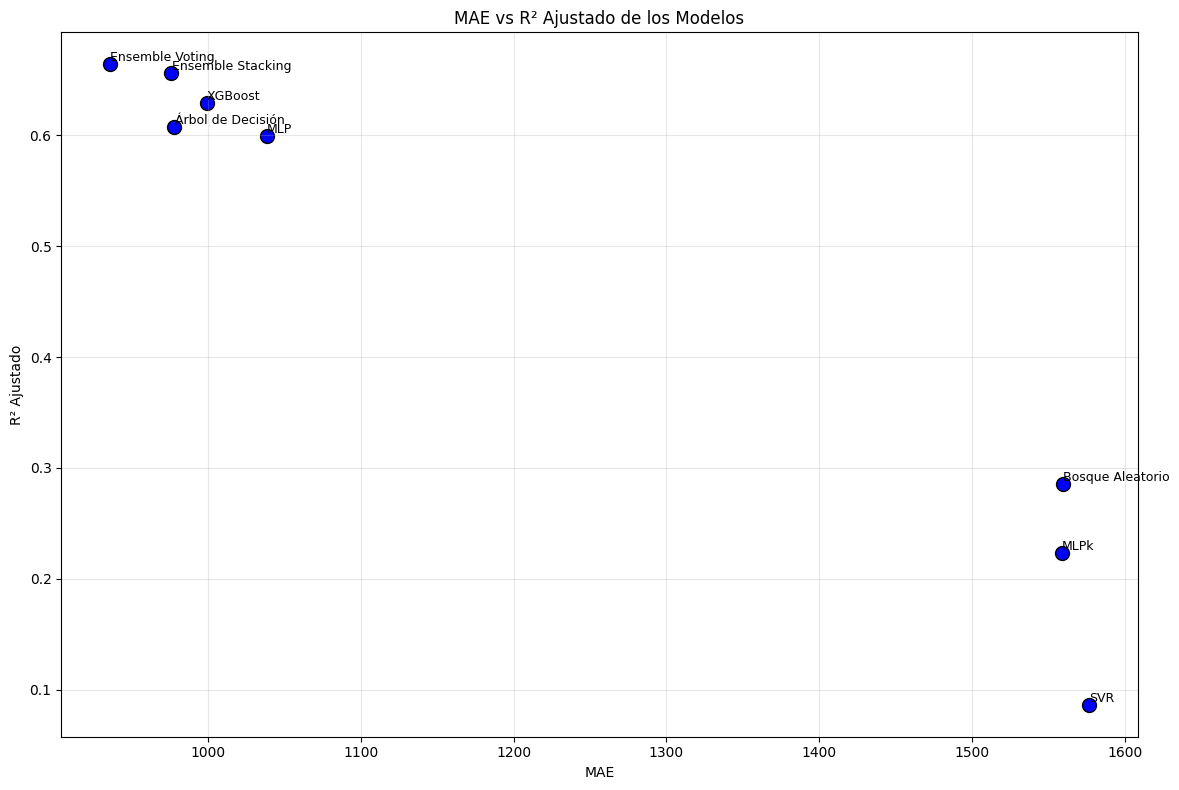

In [ ]:
import matplotlib.pyplot as plt
import warnings

# Ignorar advertencias de fuentes
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')

# Configurar fuente estándar
plt.rcParams['font.family'] = 'DejaVu Sans'

# Supón que ya tienes estos valores calculados para cada modelo
models = ['Árbol de Decisión', 'Bosque Aleatorio', 'XGBoost', 'SVR', 'Ensemble Voting', 'Ensemble Stacking', 'MLP', 'MLPk']
r2_adjusted = [r2_adj_tree, r2_adj_RandomForest, r2_adj_XGB, r2_adj_SVR, r2_adj_ensemble, r2_adj_stacking, r2_adj_MLP, r2_adj_MLPk]
mae = [MAE_tree, MAE_RandomForest, MAE_XGB, MAE_SVR, MAE_ensemble, MAE_stacking, MAE_MLP, MAE_MLPk]

# Crear el gráfico de dispersión
plt.figure(figsize=(12, 8))
plt.scatter(mae, r2_adjusted, color='blue', s=100, edgecolor='black')

# Añadir etiquetas y título
for i, model in enumerate(models):
    # Ajustamos las posiciones de las etiquetas para que no se solapen con los puntos
    plt.text(mae[i] + 0.1, r2_adjusted[i], model, fontsize=9, ha='left', va='bottom')

plt.title('MAE vs R² Ajustado de los Modelos')
plt.xlabel('MAE')
plt.ylabel('R² Ajustado')
plt.grid(True, alpha=0.3)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

#### R2 ajustado vs RMSE

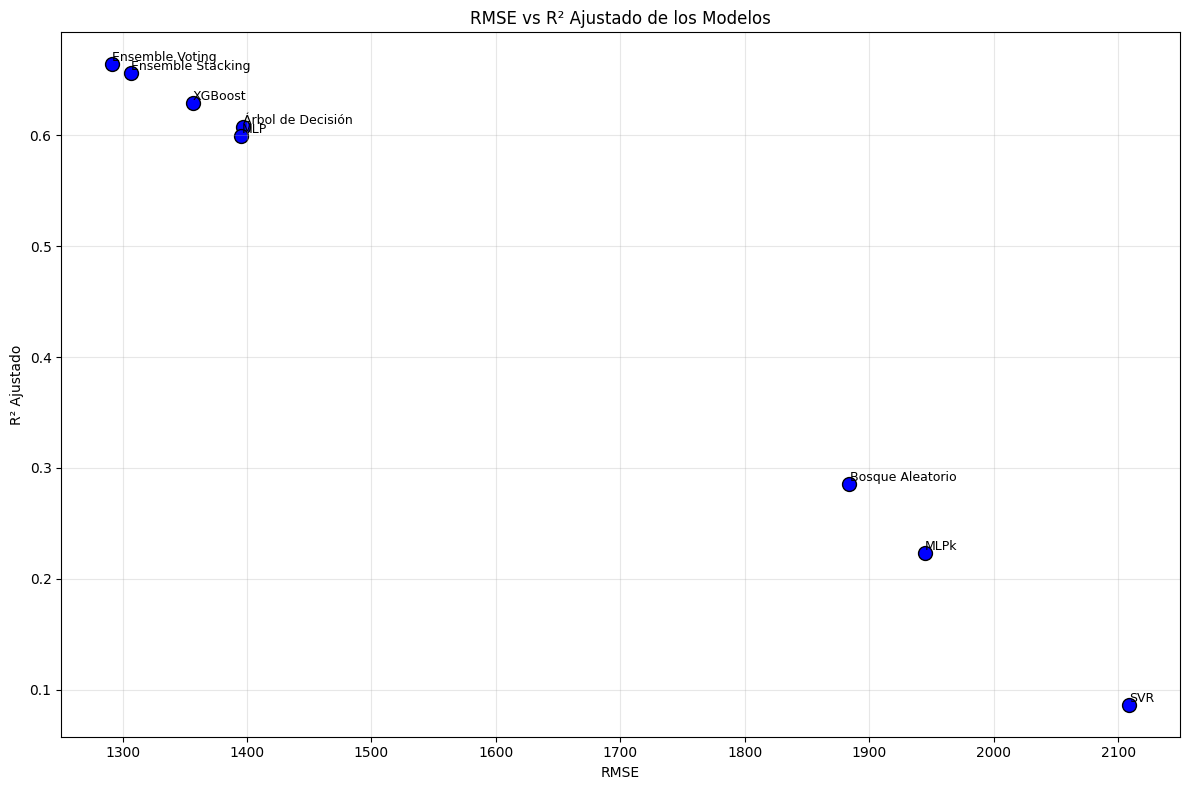

In [ ]:
import matplotlib.pyplot as plt
import warnings

# Ignorar advertencias de fuentes
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')

# Configurar fuente estándar
plt.rcParams['font.family'] = 'DejaVu Sans'

# Supón que ya tienes estos valores calculados para cada modelo
models = ['Árbol de Decisión', 'Bosque Aleatorio', 'XGBoost', 'SVR', 'Ensemble Voting', 'Ensemble Stacking', 'MLP', 'MLPk']
r2_adjusted = [r2_adj_tree, r2_adj_RandomForest, r2_adj_XGB, r2_adj_SVR, r2_adj_ensemble, r2_adj_stacking, r2_adj_MLP, r2_adj_MLPk]
rmse = [rmse_tree, rmse_RandomForest, rmse_XGB, rmse_SVR, rmse_ensemble, rmse_stacking, rmse_MLP, rmse_MLPk]

# Crear el gráfico de dispersión
plt.figure(figsize=(12, 8))
plt.scatter(rmse, r2_adjusted, color='blue', s=100, edgecolor='black')

# Añadir etiquetas y título
for i, model in enumerate(models):
    # Ajustamos las posiciones de las etiquetas para que no se solapen con los puntos
    plt.text(rmse[i] + 0.1, r2_adjusted[i], model, fontsize=9, ha='left', va='bottom')

plt.title('RMSE vs R² Ajustado de los Modelos')
plt.xlabel('RMSE')
plt.ylabel('R² Ajustado')
plt.grid(True, alpha=0.3)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Diagrama de barras R2 ajustado, MAE y RMSE

---



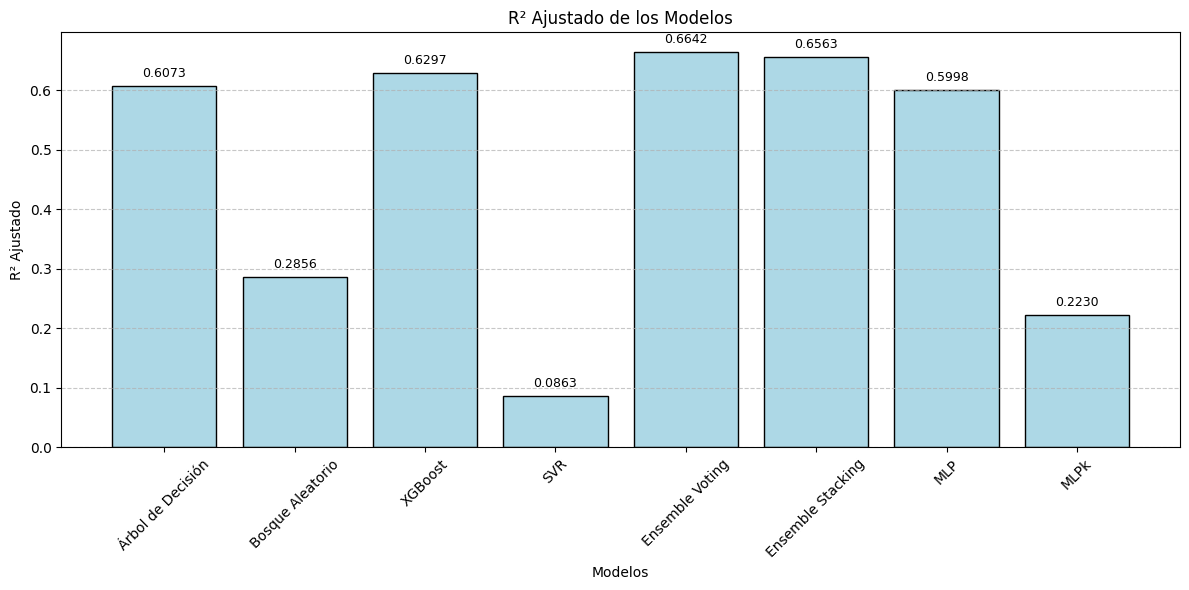

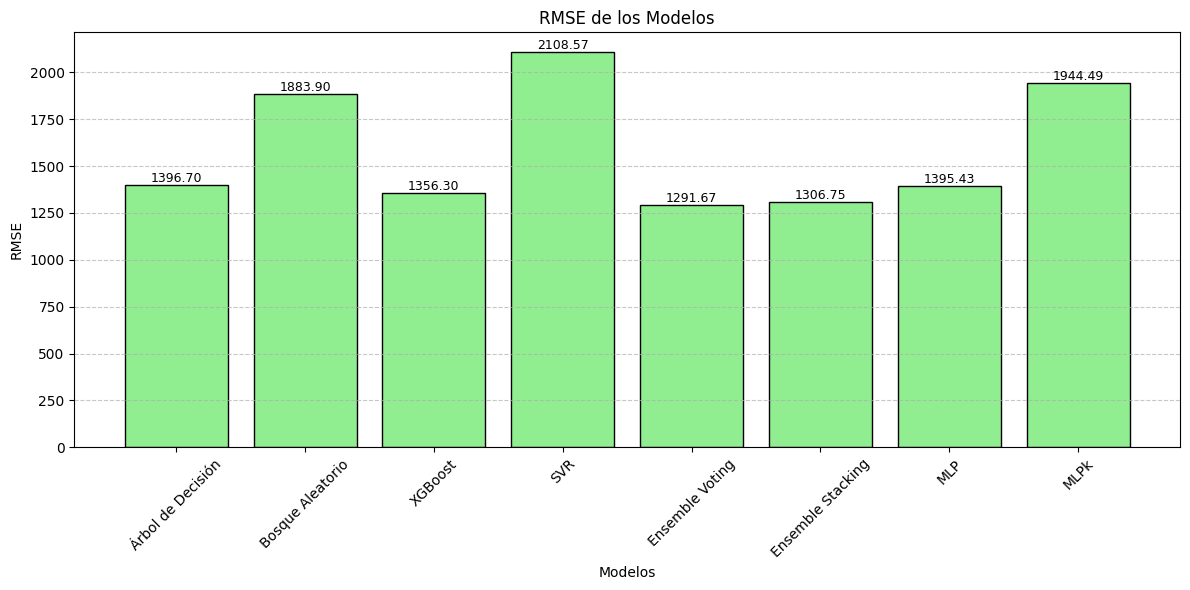

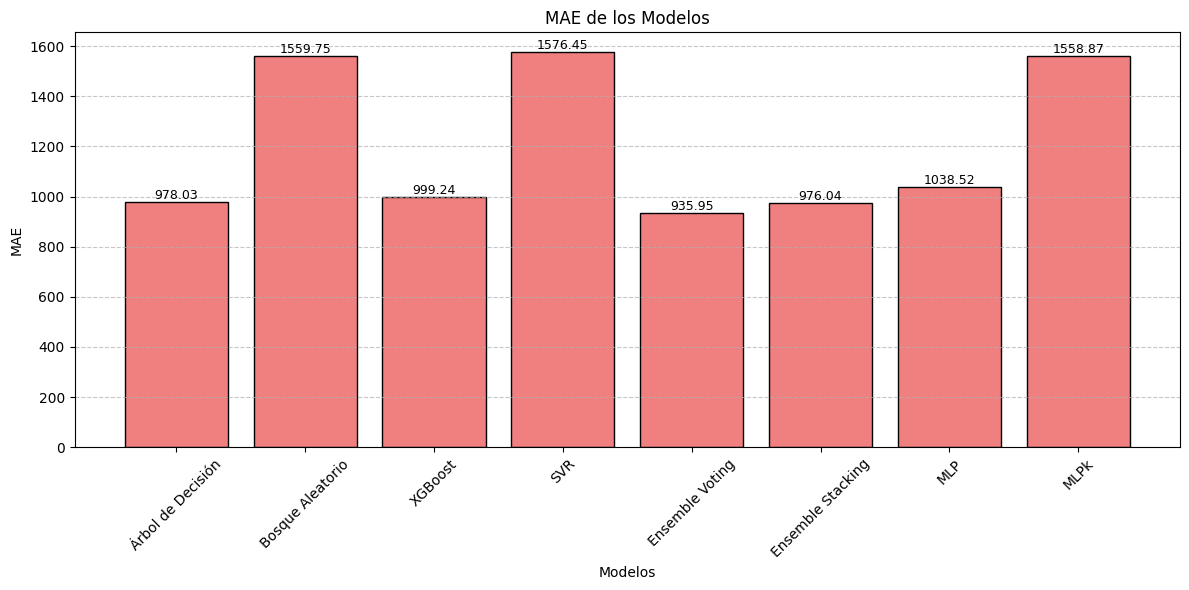

In [ ]:
import matplotlib.pyplot as plt
import warnings

# Ignorar advertencias de fuentes
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')

# Configurar fuente estándar
plt.rcParams['font.family'] = 'DejaVu Sans'

# Supón que ya tienes estos valores calculados para cada modelo
models = ['Árbol de Decisión', 'Bosque Aleatorio', 'XGBoost', 'SVR', 'Ensemble Voting', 'Ensemble Stacking', 'MLP', 'MLPk']
r2_adjusted = [r2_adj_tree, r2_adj_RandomForest, r2_adj_XGB, r2_adj_SVR, r2_adj_ensemble, r2_adj_stacking, r2_adj_MLP, r2_adj_MLPk]
mae = [MAE_tree, MAE_RandomForest, MAE_XGB, MAE_SVR, MAE_ensemble, MAE_stacking, MAE_MLP, MAE_MLPk]

# Crear el gráfico de barras para R² ajustado
plt.figure(figsize=(12, 6))  # Aumenté el ancho para acomodar 7 modelos
bars1 = plt.bar(models, r2_adjusted, color='lightblue', edgecolor='black')
plt.title('R² Ajustado de los Modelos')
plt.xlabel('Modelos')
plt.ylabel('R² Ajustado')
plt.xticks(rotation=45)  # Girar etiquetas del eje X para que no se tapen
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir valores encima de las barras
for bar, value in zip(bars1, r2_adjusted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Crear el gráfico de barras para RMSE
plt.figure(figsize=(12, 6))  # Aumenté el ancho para acomodar 7 modelos
bars2 = plt.bar(models, rmse, color='lightgreen', edgecolor='black')
plt.title('RMSE de los Modelos')
plt.xlabel('Modelos')
plt.ylabel('RMSE')
plt.xticks(rotation=45)  # Girar etiquetas del eje X para que no se tapen
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir valores encima de las barras
for bar, value in zip(bars2, rmse):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Crear el gráfico de barras para MAE
plt.figure(figsize=(12, 6))  # Aumenté el ancho para acomodar 7 modelos
bars3 = plt.bar(models, mae, color='lightcoral', edgecolor='black')
plt.title('MAE de los Modelos')
plt.xlabel('Modelos')
plt.ylabel('MAE')
plt.xticks(rotation=45)  # Girar etiquetas del eje X para que no se tapen
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir valores encima de las barras
for bar, value in zip(bars3, mae):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Grafica de pontos


MLPk - forma corregida: (110,)
Stacking - forma corregida: (113,)
=== VERIFICACIÓN DE LONGITUDES Y FORMAS ===
Longitud de y_test: 113
Árbol de Decisión: longitud 113, forma (113,)
Bosque Aleatorio: longitud 113, forma (113,)
XGBoost: longitud 113, forma (113,)
SVR: longitud 110, forma (110,)
Ensemble Voting: longitud 113, forma (113,)
Ensemble Stacking: longitud 113, forma (113,)
MLP: longitud 110, forma (110,)
MLPk: longitud 110, forma (110,)
✅ Árbol de Decisión - forma corregida: 113
✅ Bosque Aleatorio - forma corregida: 113
✅ XGBoost - forma corregida: 113
✅ SVR - forma corregida: 110
✅ Ensemble Voting - forma corregida: 113
✅ Ensemble Stacking - forma corregida: 113
✅ MLP - forma corregida: 110
✅ MLPk - forma corregida: 110


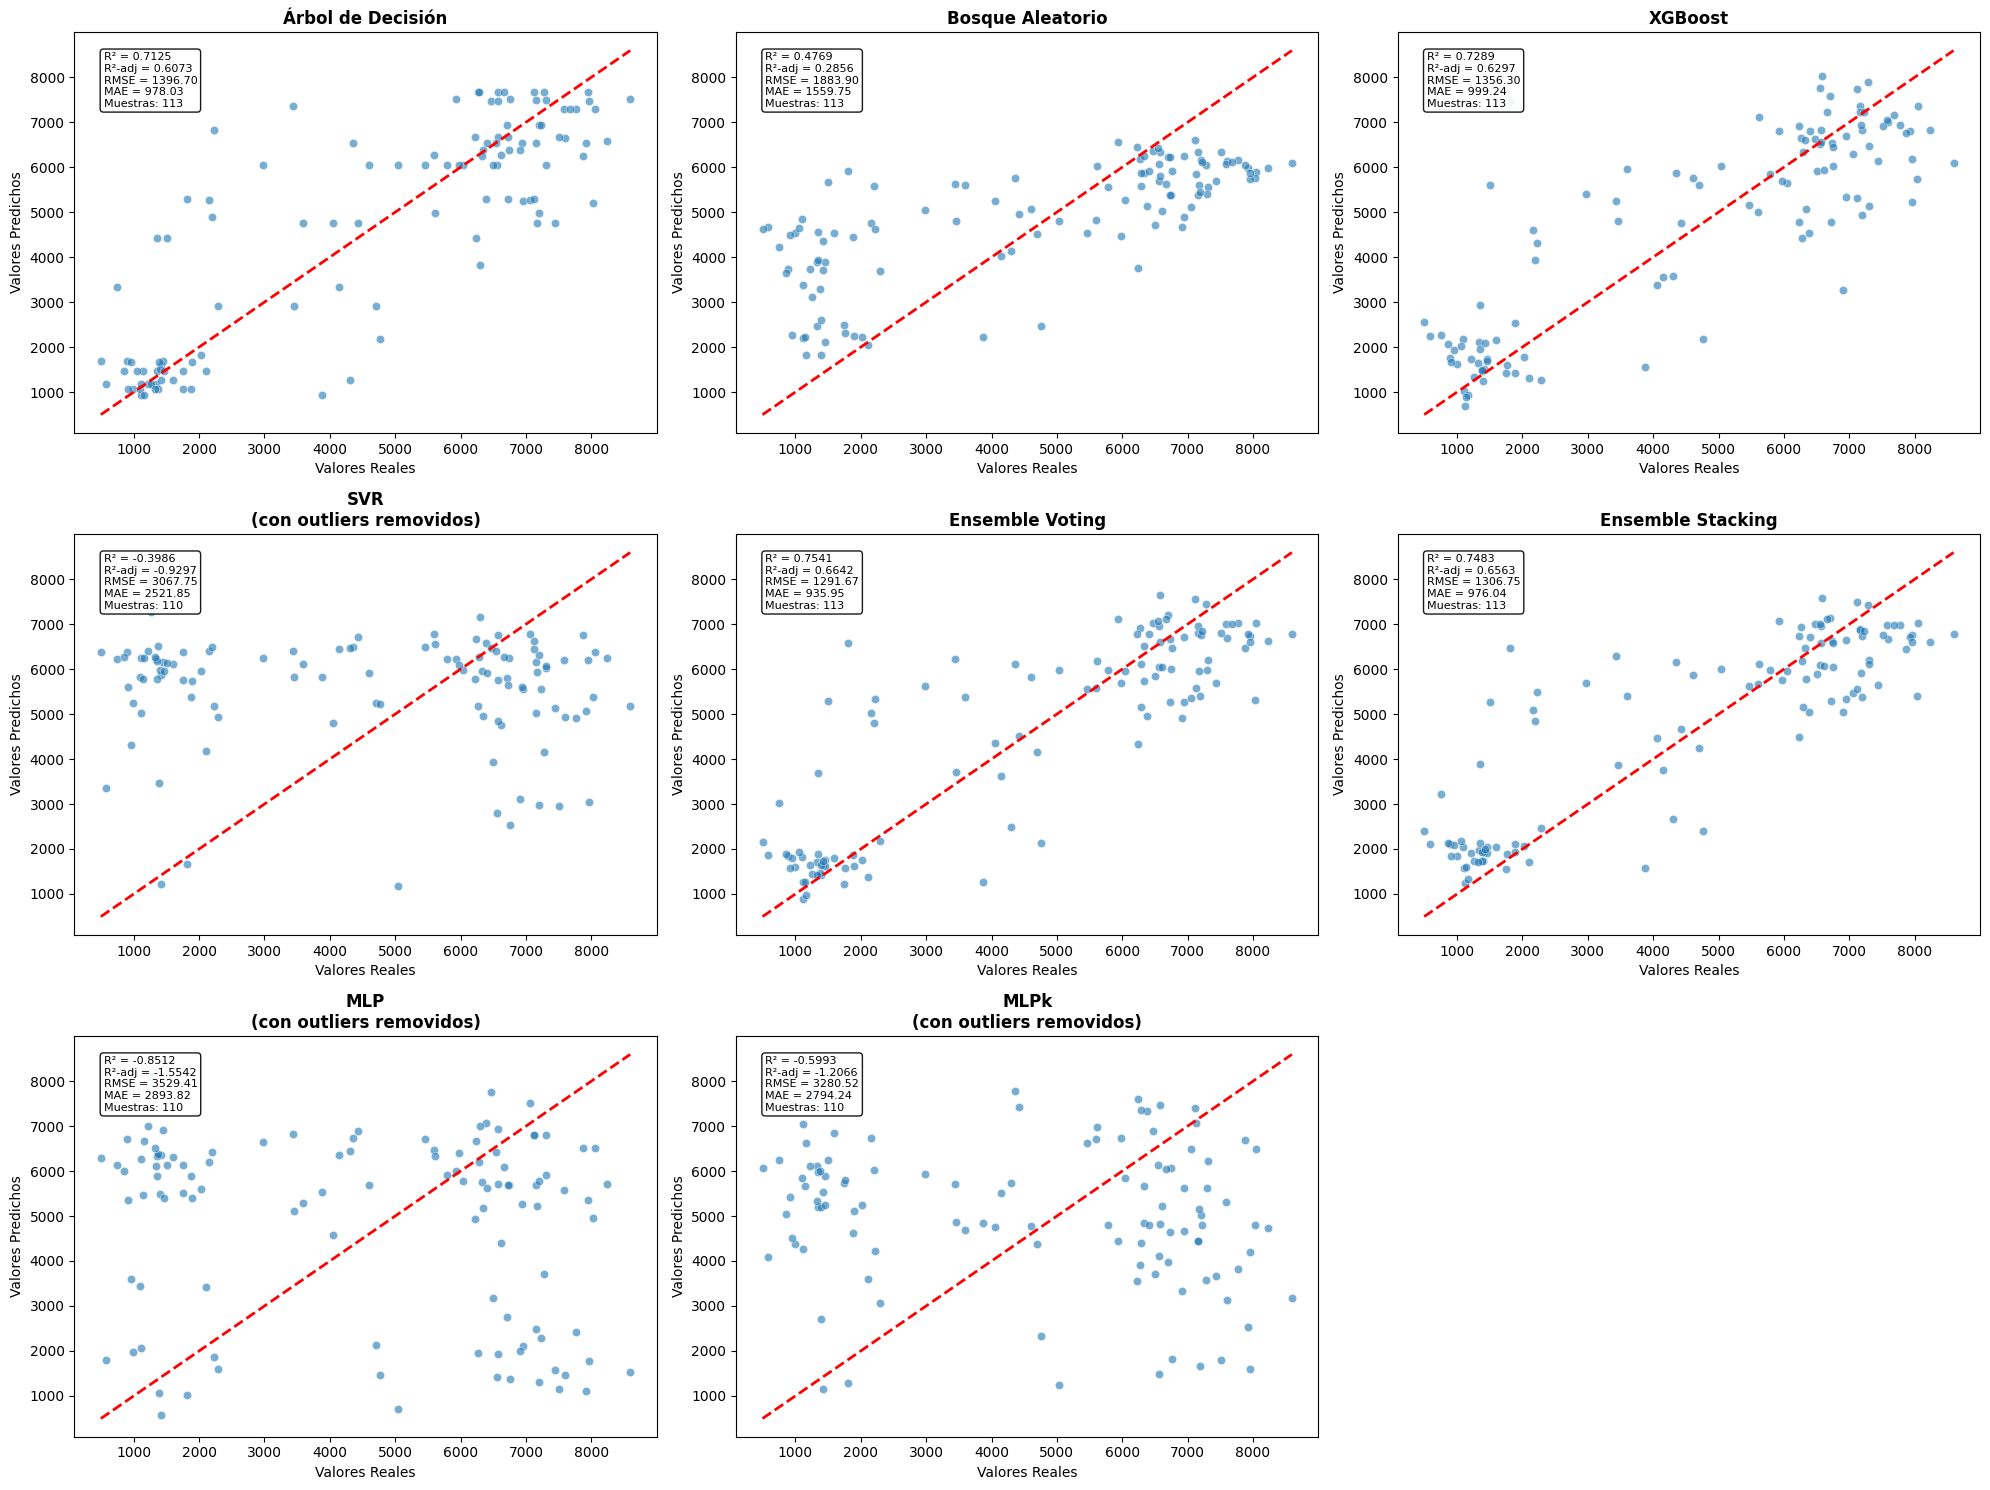


TABLA RESUMEN DE MÉTRICAS POR MODELO
Modelo               R²       R²-adj   RMSE     MAE      Muestras  
--------------------------------------------------------------------------------
Árbol de Decisión    0.7125   0.6073   1396.70     978.03     113       
Bosque Aleatorio     0.4769   0.2856   1883.90     1559.75     113       
XGBoost              0.7289   0.6297   1356.30     999.24     113       
SVR                  -0.3986   -0.9297   3067.75     2521.85     110       
Ensemble Voting      0.7541   0.6642   1291.67     935.95     113       
Ensemble Stacking    0.7483   0.6563   1306.75     976.04     113       
MLP                  -0.8512   -1.5542   3529.41     2893.82     110       
MLPk                 -0.5993   -1.2066   3280.52     2794.24     110       

RANKING FINAL POR R² AJUSTADO
Pos  Modelo               R²-adj   RMSE     MAE     
------------------------------------------------------------
1    Ensemble Voting      0.6642   1291.67     935.95
2    Ensemble Stacki

,Modelo,R²-adj,RMSE,MAE,Muestras
4,Ensemble Voting,0.6642,1291.67,935.95,113
5,Ensemble Stacking,0.6563,1306.75,976.04,113
2,XGBoost,0.6297,1356.30,999.24,113
0,Árbol de Decisión,0.6073,1396.70,978.03,113
1,Bosque Aleatorio,0.2856,1883.90,1559.75,113
3,SVR,-0.9297,3067.75,2521.85,110
7,MLPk,-1.2066,3280.52,2794.24,110
6,MLP,-1.5542,3529.41,2893.82,110


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Ignorar advertencias de fuentes
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')

# Configurar fuente estándar
plt.rcParams['font.family'] = 'DejaVu Sans'

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# CORREGIR FORMA DE MLPk (TensorFlow/Keras)
if 'y_pred_MLPk' in globals():
    # TensorFlow devuelve array 2D, convertir a 1D
    y_pred_MLPk = y_pred_MLPk.flatten() if hasattr(y_pred_MLPk, 'flatten') else y_pred_MLPk
    print(f"MLPk - forma corregida: {y_pred_MLPk.shape}")

# CORREGIR FORMA DE STACKING
if 'y_pred_stacking' in globals():
    y_pred_stacking = y_pred_stacking.flatten() if hasattr(y_pred_stacking, 'flatten') else y_pred_stacking
    print(f"Stacking - forma corregida: {y_pred_stacking.shape}")

# Diccionario con las predicciones (AGREGADO STACKING)
models_preds = {
    "Árbol de Decisión": y_pred_tree,
    "Bosque Aleatorio": y_pred_RandomForest,
    "XGBoost": y_pred_XGB,
    "SVR": y_pred_SVR,
    "Ensemble Voting": y_pred_ensemble,
    "Ensemble Stacking": y_pred_stacking,  # ← NUEVO
    "MLP": y_pred_MLP,
    "MLPk": y_pred_MLPk
}

# VERIFICAR LONGITUDES Y FORMAS
print("=== VERIFICACIÓN DE LONGITUDES Y FORMAS ===")
print(f"Longitud de y_test: {len(y_test)}")
for name, y_pred in models_preds.items():
    if hasattr(y_pred, 'shape'):
        print(f"{name}: longitud {len(y_pred)}, forma {y_pred.shape}")
    else:
        print(f"{name}: longitud {len(y_pred)}")

# SOLUCIÓN MEJORADA: Asegurar que todas las predicciones sean 1D
models_preds_corregido = {}
for name, y_pred in models_preds.items():
    try:
        # Convertir a 1D si es necesario
        if hasattr(y_pred, 'flatten'):
            y_pred_corregido = y_pred.flatten()
        elif hasattr(y_pred, 'reshape'):
            y_pred_corregido = y_pred.reshape(-1)
        else:
            y_pred_corregido = y_pred

        models_preds_corregido[name] = y_pred_corregido
        print(f"✅ {name} - forma corregida: {len(y_pred_corregido)}")

    except Exception as e:
        print(f"❌ Error corrigiendo {name}: {e}")
        continue

# GRAFICAR (AJUSTADO PARA 9 MODELOS - 3x3)
plt.figure(figsize=(20, 15))
model_count = 0

for i, (name, y_pred) in enumerate(models_preds_corregido.items(), 1):
    try:
        # Para modelos con diferente longitud, usar y_test compatible
        if len(y_pred) != len(y_test):
            y_test_compatible = y_test[:len(y_pred)]
            n_samples = len(y_pred)
            p_features = X_test.shape[1] if 'X_test' in globals() else 30  # Asumir 30 características

            plt.subplot(3, 3, i)
            sns.scatterplot(x=y_test_compatible, y=y_pred, alpha=0.6)
            plt.plot([y_test_compatible.min(), y_test_compatible.max()],
                     [y_test_compatible.min(), y_test_compatible.max()],
                     'r--', linewidth=2)
            title_suffix = "\n(con outliers removidos)" if name in ["SVR", "MLP", "MLPk"] else ""
            plt.title(f"{name}{title_suffix}", fontsize=12, fontweight='bold')

        else:
            y_test_compatible = y_test
            n_samples = len(y_test)
            p_features = X_test.shape[1] if 'X_test' in globals() else 30

            plt.subplot(3, 3, i)
            sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
            plt.plot([y_test.min(), y_test.max()],
                     [y_test.min(), y_test.max()],
                     'r--', linewidth=2)
            plt.title(f"{name}", fontsize=12, fontweight='bold')  # ← HOMOGÉNEO PARA TODOS

        plt.xlabel("Valores Reales")
        plt.ylabel("Valores Predichos")

        # Calcular métricas
        r2 = r2_score(y_test_compatible, y_pred)
        r2_adj = adjusted_r2(r2, n_samples, p_features)
        rmse = np.sqrt(mean_squared_error(y_test_compatible, y_pred))
        mae = mean_absolute_error(y_test_compatible, y_pred)

        # Mostrar métricas en el gráfico (HOMOGÉNEO PARA TODOS - BLANCO)
        metric_text = f'R² = {r2:.4f}\nR²-adj = {r2_adj:.4f}\nRMSE = {rmse:.2f}\nMAE = {mae:.2f}\nMuestras: {n_samples}'

        plt.text(0.05, 0.95, metric_text,
                 transform=plt.gca().transAxes,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9),  # ← SIEMPRE BLANCO
                 fontsize=8,
                 verticalalignment='top')
        model_count += 1

    except Exception as e:
        print(f"❌ Error graficando {name}: {e}")
        continue

# Ajustar layout para 9 modelos (3x3)
plt.tight_layout()
plt.show()

# TABLA RESUMEN DE MÉTRICAS
print("\n" + "="*80)
print("TABLA RESUMEN DE MÉTRICAS POR MODELO")
print("="*80)

print(f"{'Modelo':<20} {'R²':<8} {'R²-adj':<8} {'RMSE':<8} {'MAE':<8} {'Muestras':<10}")
print("-" * 80)

for name, y_pred in models_preds_corregido.items():
    try:
        if len(y_pred) != len(y_test):
            y_test_compatible = y_test[:len(y_pred)]
            n_samples = len(y_pred)
        else:
            y_test_compatible = y_test
            n_samples = len(y_test)

        p_features = X_test.shape[1] if 'X_test' in globals() else 30
        r2 = r2_score(y_test_compatible, y_pred)
        r2_adj = adjusted_r2(r2, n_samples, p_features)
        rmse = np.sqrt(mean_squared_error(y_test_compatible, y_pred))
        mae = mean_absolute_error(y_test_compatible, y_pred)

        print(f"{name:<20} {r2:.4f}   {r2_adj:.4f}   {rmse:.2f}     {mae:.2f}     {n_samples:<10}")

    except Exception as e:
        print(f"{name:<20} ERROR: {e}")

# print(f"\n✅ Se graficaron {model_count} de {len(models_preds_corregido)} modelos correctamente")

# TABLA COMPARATIVA FINAL ORDENADA POR R² AJUSTADO (SIN EMOJIS)
print("\n" + "="*80)
print("RANKING FINAL POR R² AJUSTADO")
print("="*80)

ranking_data = []
for name, y_pred in models_preds_corregido.items():
    try:
        if len(y_pred) != len(y_test):
            y_test_compatible = y_test[:len(y_pred)]
            n_samples = len(y_pred)
        else:
            y_test_compatible = y_test
            n_samples = len(y_test)

        p_features = X_test.shape[1] if 'X_test' in globals() else 30
        r2 = r2_score(y_test_compatible, y_pred)
        r2_adj = adjusted_r2(r2, n_samples, p_features)
        rmse = np.sqrt(mean_squared_error(y_test_compatible, y_pred))
        mae = mean_absolute_error(y_test_compatible, y_pred)

        ranking_data.append({
            'Modelo': name,
            'R²': r2,
            'R²-adj': r2_adj,
            'RMSE': rmse,
            'MAE': mae,
            'Muestras': n_samples
        })
    except Exception as e:
        continue

# Crear DataFrame y ordenar por R² ajustado
ranking_df = pd.DataFrame(ranking_data)
ranking_df = ranking_df.sort_values('R²-adj', ascending=False)

# Mostrar ranking SIN EMOJIS
print(f"{'Pos':<4} {'Modelo':<20} {'R²-adj':<8} {'RMSE':<8} {'MAE':<8}")
print("-" * 60)
for i, (idx, row) in enumerate(ranking_df.iterrows(), 1):
    print(f"{i:<4} {row['Modelo']:<20} {row['R²-adj']:.4f}   {row['RMSE']:.2f}     {row['MAE']:.2f}")

# TABLA FINAL BONITA CON PANDAS
print("\n" + "="*80)
print("COMPARACIÓN FINAL DE MODELOS (ORDENADO POR R² AJUSTADO)")
print("="*80)

final_comparison = ranking_df[['Modelo', 'R²-adj', 'RMSE', 'MAE', 'Muestras']].copy()
final_comparison['R²-adj'] = final_comparison['R²-adj'].round(4)
final_comparison['RMSE'] = final_comparison['RMSE'].round(2)
final_comparison['MAE'] = final_comparison['MAE'].round(2)

display(final_comparison.style.format({
    'R²-adj': '{:.4f}',
    'RMSE': '{:.2f}',
    'MAE': '{:.2f}'
}))

## Reporte final



| Algoritmo | Hiperparâmetros | Combinações | Parâmetros Ótimos | Métricas (Teste) | Validação Cruzada (K=5) |
|-----------|----------------|-------------|-------------------|------------------|------------------------|
| Árvore de Decisão | max_depth: [3, 5, 10, 15, 20, None]<br>min_samples_split: [2, 5, 10, 20]<br>min_samples_leaf: [1, 2, 4, 8] | 96 | max_depth: 10<br>min_samples_split: 5<br>min_samples_leaf: 4 | R² ajustado: 0.6073<br>MAE: 978.03<br>RMSE: 1396.70 | R² ajustado: 0.4288<br>RMSE: 1780.13<br>MAE: 1194.17 |
| Random Forest | n_estimators: [100, 200, 300]<br>max_depth: [3, 5, 8, 10, 15, 20, None]<br>min_samples_split: [5, 10, 15, 20]<br>min_samples_leaf: [2, 4, 8, 12]<br>max_features: ['sqrt']<br>max_samples: [0.6, 0.7, 0.8, 1.0] | 1008 | n_estimators: 200<br>max_depth: 20<br>min_samples_split: 5<br>min_samples_leaf: 2<br>max_samples: 1.0 | R² ajustado: 0.2856<br>MAE: 1559.75<br>RMSE: 1883.90 | R² ajustado: 0.2877<br>RMSE: 1999.87<br>MAE: 1626.67 |
| XGBoost | n_estimators: [100, 200, 300]<br>max_depth: [3, 5, 7, 8]<br>learning_rate: [0.05, 0.1, 0.2]<br>subsample: [0.7, 0.8, 1.0]<br>colsample_bytree: [0.7, 0.8, 1.0]<br>reg_alpha: [0, 1, 10]<br>reg_lambda: [1, 10] | 1296 | n_estimators: 100<br>max_depth: 5<br>learning_rate: 0.2<br>subsample: 1.0<br>colsample_bytree: 0.7<br>reg_alpha: 1.0<br>reg_lambda: 1.0 | R² ajustado: 0.6297<br>MAE: 999.24<br>RMSE: 1356.30 | R² ajustado: 0.4435<br>RMSE: 1760.63<br>MAE: 1227.98 |
| SVM | kernel: ['linear', 'rbf']<br>C: [0.1, 1, 10]<br>epsilon: [0.05, 0.1, 0.2]<br>gamma: ['scale', 'auto'] | 36 | kernel: 'linear'<br>C: 10.0<br>epsilon: 0.2<br>gamma: 'auto' | R² ajustado: 0.0863<br>MAE: 1576.45<br>RMSE: 2108.57 | R² ajustado: 0.2314<br>RMSE: 2073.06<br>MAE: 1581.72 |
| Ensemble (Voto) | combinações_testadas: 10 combinações de pesos entre Árvore, RF e XGBoost | 10 | combinação: Todos_Iguales<br>modelos: Árvore, RF, XGBoost<br>pesos: [1, 1, 1] | R² ajustado: 0.6642<br>MAE: 935.95<br>RMSE: 1291.67 | R² ajustado: 0.4956<br>RMSE: 1677.69<br>MAE: 1169.23 |
| Ensemble (Stacking) | configuração: Stacking com 3 modelos base + meta-modelo | 1 | modelos_base: Árvore, RF, XGBoost<br>meta_modelo: LinearRegression | R² ajustado: 0.6563<br>MAE: 976.04<br>RMSE: 1306.75 | R² ajustado: 0.4883<br>RMSE: 1688.19<br>MAE: 1184.73 |
| MLP (Keras) | hidden_layers: [[32, 16], [64, 32]]<br>activation: ['relu', 'leaky_relu']<br>learning_rate: [0.001, 0.0005]<br>batch_size: [16, 32]<br>dropout_rate: [0.2, 0.3]<br>l2_regularization: [0.001, 0.01]<br>epochs: [150, 200]<br>use_batch_norm: [True, False] | 256 | capas_ocultas: [64, 32]<br>ativação: 'relu'<br>learning_rate: 0.001<br>batch_size: 16<br>dropout: 0.2<br>l2_regularization: 0.01<br>batch_norm: False | R² ajustado: 0.2500<br>MAE: 1533.58<br>RMSE: N/A | R² ajustado: N/A<br>RMSE: N/A<br>MAE: N/A |
| MLP (Sklearn) | hidden_layer_sizes: [(50,), (100,), (50, 50), (100, 50), (100, 100), (50, 25, 10)]<br>activation: ['relu', 'tanh']<br>alpha: [0.0001, 0.001, 0.01]<br>learning_rate_init: [0.01, 0.005]<br>batch_size: ['auto', 32] | 144 | arquitetura: (50, 50)<br>ativação: 'relu'<br>alpha: 0.001<br>learning_rate: 0.01<br>batch_size: 32 | R² ajustado: 0.5998<br>MAE: 1038.52<br>RMSE: 1395.43 | R² ajustado: 0.5569<br>RMSE: 1577.79<br>MAE: 1131.66 |